In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import csv

from scipy.interpolate import make_interp_spline, make_lsq_spline
import rpy2.robjects as robjects
import pyreadr
import sys
import csv

sys.path.append("../../src/Utility")

from utility import plot_multiple_roc
from os.path import exists

In [3]:
path="../../result_intel/results11/"


In [339]:
def remove_duplicate(x,y):
    unique_v, idx, count = np.unique(x, return_inverse=True, return_counts=True)
    m = np.zeros((unique_v.size, 2))
    m[:,0] = unique_v
    duplicate_v = np.where(count>1)[0]
    for i in duplicate_v:
        j = np.where(idx==i)[0]
        mean_val = np.mean(y[j])
        m[ i, 1] = mean_val
    single_v = np.where(count==1)[0]
    for i in single_v:
        j = np.where(idx==i)[0]
        m[i,1] = y[j]
    return m


def remove_outlier(data_list, a=2):
    mean = np.mean(data_list)
    std = np.std(data_list)
    keep = np.intersect1d(np.where(data_list <= mean + a*std)[0], np.where(data_list >= mean - a*std)[0])
    keep = np.array(keep)

    out = [data_list[x] for x in keep]
    return out

In [303]:
def drop_intermediate(fpr, tpr):
    #needs to be sorted
    #assert(len(fpr)>2)

    #optimal_idxs = np.where(
    #    np.r_[True, np.where(np.diff(tpr, 1)> -1e-5)[0]]
    #)[0]
    #fpr_diff = np.diff(fpr, 1)
    #tpr_diff = np.diff(tpr, 1)

    #ratio_tfpr = tpr_diff/fpr_diff
    #optimal_idxs = np.where(
    #    np.r_[True, np.where(np.abs(ratio_tfpr)< 20)[0]]
    #)[0]
    #fpr = fpr[optimal_idxs]
    #tpr = tpr[optimal_idxs]

    return fpr, tpr
       

In [253]:
def calculate_auc(m):
    #m is ndarray and m[:,0] denotes the fpr and m[:,1] are tpr

    X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
    X_ = 1
    Y_ = X_Y_Spline(X_)
    x_sort = np.sort(m[:,0])
    sort_id = np.argsort(m[:, 0])
    y_sort = m[sort_id, 1]
    x_sort = np.concatenate(([0], x_sort, [1]))
    y_sort = np.concatenate(([0], y_sort, [Y_]))
    n = x_sort.size
    area = 0
    for i in range(n-1):
        x_interval = x_sort[i+1]-x_sort[i]
        y_average = (y_sort[i] + y_sort[i+1])/2
        area += x_interval*y_average
    return area


def calculate_auc15(m):
    #m is ndarray and m[:,0] denotes the fpr and m[:,1] are tpr
    X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
    X_ = 0.15
    Y_ = X_Y_Spline(X_)
    id = np.where(m[:,0]<=0.15)[0]
    x = m[id,0]
    y = m[id,1]
    x_sort = np.sort(x)
    
    sort_id = np.argsort(x)
    y_sort = y[sort_id]
    x_sort = np.concatenate(([0], x_sort, [0.15]))
    y_sort = np.concatenate(([0], y_sort, [Y_]))
    n = x_sort.size
    area = 0
    for i in range(n-1):
        x_interval = x_sort[i+1]-x_sort[i]
        y_average = (y_sort[i] + y_sort[i+1])/2
        area += x_interval*y_average
    return area/0.15



In [254]:
def plot_multiple_roc(file_list, name_list, title=None, nknot=10, scatter=False):
    for file, name in zip(file_list, name_list):
        arr = np.load(file)
        sort_fpr = np.argsort(arr[:,1])

        arr2 = np.zeros(arr.shape)
        arr2[:,0] = arr[sort_fpr,0]
        arr2[:,1] = arr[sort_fpr,1]

        m = remove_duplicate(arr2[:,1], arr2[:,0])
        #m = np.vstack((np.array([0,0]), m))
        X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
        X_ = np.linspace(0, np.max(arr2[:, 1]), nknot)
        Y_ = X_Y_Spline(X_)
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o', label=name)
        plt.legend()
        if scatter:
            plt.scatter(arr2[:,1], arr2[:,0])
        #plt.scatter(m[:,0], m[:,1], )

    
    x = np.arange(0,1.1,.1)
    plt.plot(x,x,color='k')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if title is not None:
        plt.title(title)


#### to check $b$ of JFGGM

200


max_i 1 max_area 0.7508058763073575


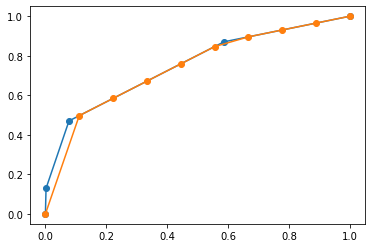

In [255]:
filename="../../result_intel/results_c10/tridiag2_p100_N100_noise1_jfggm_stage2.RunInd4.Rdata"
obj = pyreadr.read_r(filename)
print(len(obj['roc']['TPR.jfggm']))
plt.plot(obj['roc']['TPR.jfggm'])
plt.show()

test_num = len(obj['roc']['TPR.jfggm']) // 50
max_area = 0
max_i = -1

#select b that has the largest ROC
for i in range(test_num):
    tpr_jfggm = obj['roc']['TPR.jfggm'][i*50:(i+1)*50]
    fpr_jfggm = obj['roc']['FPR.jfggm'][i*50:(i+1)*50]
    m = remove_duplicate(fpr_jfggm , tpr_jfggm)
    area = calculate_auc(m)
    if area >= max_area:
        max_area = area
        max_i = i
print('max_i', max_i, 'max_area', max_area)

tpr_jfggm = obj['roc']['TPR.jfggm'][max_i*50:(max_i+1)*50]
fpr_jfggm = obj['roc']['FPR.jfggm'][max_i*50:(max_i+1)*50]
m = remove_duplicate(fpr_jfggm , tpr_jfggm)

plt.plot(m[:,0], m[:,1], '-o', label="jfggm")
X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
X_ = np.linspace(np.min(m[:, 0]), np.max(m[:, 0]), 10)
Y_ = X_Y_Spline(X_)
#plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
plt.plot(X_, Y_, '-o', label='jfggm2')

In [256]:

#file_list=['power_p150_N50', 'random_p150_N100', 'random_p150_N500']
def plotplot(gid, axlist, graphname, noise_model, N):
    file_list = list()
    p_list = [50,100,150]
    basefile = '{}'.format(graphname)
    for i in p_list:
        file_list.append(basefile+'_p{}_N{}'.format(i, N))
    
    #fig.suptitle('ROC curve of graph {}, N={}'.format(gid, N))
    i = 1
    for ax,filename in zip(axlist,file_list):
        #ax.subplot(1, 4, i)
        if (gid==1):
            ax.title.set_text("p={}".format(p_list[i-1]))
        #if i ==1:
        #    plt.ylabel('TPR')
        #if i == 2:
        #    plt.xlabel('FPR')
        i+=1
        if(gid==1):
            x = 322
        if(gid==2):
            x = 232
        if(gid==3):
            x = 342
        if(gid==4):
            x = 432
        if(gid==5):
            x = 332
        p_file = model_path1+"model3_"+filename+"_Iest_" + noise_model +"thre0.001_rate{}_run8_tprfpr.npy".format(x)
        if not exists(p_file):
            p_file = model_path+"model3_"+filename+"_Iest_" + noise_model +"run8_thre1000_tprfpr.npy"
        if not exists(p_file):
            p_file = model_path+"model3_"+filename+"_Iest_" + noise_model +"thre0.001_rate332_run8_tprfpr.npy"

        arr = np.load(p_file)
        sort_fpr = np.argsort(arr[:,1])

        flng = np.zeros(arr.shape)
        flng[:,0] = arr[sort_fpr,0]
        flng[:,1] = arr[sort_fpr,1]
        auc_q, auc_p, auc_z = 0,0,0
        m = remove_duplicate(flng[:,1], flng[:,0])
        auc_p = calculate_auc15(m)
        if m.shape[0]<=4:
            ax.step(m[:,0], m[:,1], '-o', where='post', label="proposed model")
        else:
            p_fpr, p_tpr= drop_intermediate(m[:,0],m[:,1])
            X_Y_Spline = make_interp_spline(p_fpr, p_tpr, k=1)
            X_ = np.linspace(np.min(p_fpr), np.max(p_fpr), 10)
            Y_ = X_Y_Spline(X_)
            #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
            ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='solid', label="proposed model")
        """
        p_file = model_path+"model3_"+filename+"_Iest_" + noise_model +"_run8_thre1000_trueparam_tprfpr.npy"
        if exists(p_file):
            arr = np.load(p_file)
            sort_fpr = np.argsort(arr[:,1])

            flng = np.zeros(arr.shape)
            flng[:,0] = arr[sort_fpr,0]
            flng[:,1] = arr[sort_fpr,1]

            m = remove_duplicate(flng[:,1], flng[:,0])

            if m.shape[0]<=4:
                ax.step(m[:,0], m[:,1], '-o', where='post', label="proposed model (true A)")
            else:
                p_fpr, p_tpr= drop_intermediate(m[:,0],m[:,1])
                X_Y_Spline = make_interp_spline(p_fpr, p_tpr, k=1)
                X_ = np.linspace(np.min(p_fpr), np.max(p_fpr), 10)
                Y_ = X_Y_Spline(X_)
                #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='solid', label="proposed model (true A)")
        
        """
        #print(obj)        
        comparison_filepath = comparison_path+filename+'_'+noise_model+'light.RunInd4.Rdata'
        
        def comparison_exist():
            qiao_fpr = np.array(obj['roc']['FPR.qiao'])
            qiao_tpr = np.array(obj['roc']['TPR.qiao'])

            sort_fpr = np.argsort(qiao_fpr)

            qiao = np.zeros((qiao_tpr.shape[0], 2))
            qiao[:,0] = qiao_fpr[sort_fpr]
            qiao[:,1] = qiao_tpr[sort_fpr]
            m = remove_duplicate(qiao[:,0], qiao[:,1])
            auc_q =  calculate_auc15(m)
            if m.shape[0]<=4:
                ax.step(m[:,0], m[:,1], '-o', where='post', label='Qiao et al., 2019')
            else:
                q_fpr, q_tpr= drop_intermediate(m[:,0],m[:,1])
                X_Y_Spline = make_interp_spline(q_fpr, q_tpr, k=1)
                X_ = np.linspace(np.min(q_fpr), np.max(q_fpr), 10)
                Y_ = X_Y_Spline(X_)
                
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dotted',  label='Qiao et al., 2019')
            return auc_q
            """
            zapata_fpr = np.array(obj['roc']['FPR.zapata'])
            zapata_tpr = np.array(obj['roc']['TPR.zapata'])
            sort_fpr = np.argsort(zapata_fpr)

            zapata = np.zeros((zapata_tpr.shape[0],2))
            zapata[:,0] = zapata_fpr[sort_fpr]
            zapata[:,1] = zapata_tpr[sort_fpr]
            m = remove_duplicate(zapata[:,0], zapata[:,1])

            if m.shape[0] <= 10:
                ax.step(m[:,0], m[:,1], '-o', where='post', label='Zapata et al., 2021')
            else:
                X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
                X_ = np.linspace(np.min(m[:, 0]), np.max(m[:, 0]), 10)
                Y_ = X_Y_Spline(X_)
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-', label='Zapata et al., 2021')
            """
        qiao_filepath = comparison_path+filename+'_'+noise_model+'light_qiao.RunInd4.Rdata'
        
        if(exists(qiao_filepath)):
            obj = pyreadr.read_r(qiao_filepath)
            auc_q = comparison_exist()
        elif(exists(comparison_filepath)):
            obj = pyreadr.read_r(comparison_filepath)
            quc_q = comparison_exist()
            #print('load file from directory: '+ './results_c_vision/')
        #else:
        #print("file: "+ comparison_filepath+" not exist")
        #    pass
        #print(obj)

        
        
        def zapata_exist():
            zapata_fpr = np.array(obj['roc']['FPR.zapata'])
            zapata_tpr = np.array(obj['roc']['TPR.zapata'])
            sort_fpr = np.argsort(zapata_fpr)

            zapata = np.zeros((zapata_tpr.shape[0],2))
            zapata[:,0] = zapata_fpr[sort_fpr]
            zapata[:,1] = zapata_tpr[sort_fpr]
            m = remove_duplicate(zapata[:,0], zapata[:,1])
            auc_z =  calculate_auc15(m)
            if m.shape[0] <= 4:
                ax.step(m[:,0], m[:,1], '-o', where='post', label='Zapata et al., 2021')
            else:
                z_fpr, z_tpr= drop_intermediate(m[:,0],m[:,1])
                X_Y_Spline = make_interp_spline(z_fpr, z_tpr, k=1)
                X_ = np.linspace(np.min(z_fpr), np.max(z_tpr), 10)
                Y_ = X_Y_Spline(X_)
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashed', label='Zapata et al., 2021')
            return auc_z
        
        zapata_filepath = zapata_path + filename+'_'+noise_model+'light_zapata.RunInd4.Rdata'
        
        if(exists(zapata_filepath)):
            obj = pyreadr.read_r(zapata_filepath)
            auc_z = zapata_exist()
            #print('load file from directory: '+ './results_c_vision/')
        elif(exists(comparison_filepath)):
            auc_z = zapata_exist()
        #    pass

        def jfggm_exist():
            jfggm_fpr = np.array(obj['roc']['FPR.jfggm'])
            jfggm_tpr = np.array(obj['roc']['TPR.jfggm'])

            test_num = len(obj['roc']['TPR.jfggm']) // 50
            max_area = 0
            max_i = -1

            #select b that has the largest ROC
            for i in range(test_num):
                tpr_jfggm = obj['roc']['TPR.jfggm'][i*50:(i+1)*50]
                fpr_jfggm = obj['roc']['FPR.jfggm'][i*50:(i+1)*50]
                m = remove_duplicate(fpr_jfggm , tpr_jfggm)
                area = calculate_auc(m)
                #print("index: " , i, " area: ", area)
                if area >= max_area:
                    max_area = area
                    max_i = i

            #print(max_i)
            tpr_jfggm = obj['roc']['TPR.jfggm'][max_i*50:(max_i+1)*50]
            fpr_jfggm = obj['roc']['FPR.jfggm'][max_i*50:(max_i+1)*50]
            
            sort_fpr = np.argsort(jfggm_fpr)

            jfggm = np.zeros((jfggm_tpr.shape[0],2))
            jfggm[:,0] = jfggm_fpr[sort_fpr]
            jfggm[:,1] = jfggm_tpr[sort_fpr]
            #print(jfggm.shape)
            m = remove_duplicate(jfggm[:,0], jfggm[:,1])
            
            if m.shape[0] <= 4:
                ax.step(m[:,0], m[:,1], '-o', where='post', label="Moysidis et al., 2021")
            else:
   
                m_fpr, m_tpr= drop_intermediate(m[:,0],m[:,1])
                X_Y_Spline = make_interp_spline(m_fpr, m_tpr, k=1)
                X_ = np.linspace(np.min(m_fpr), np.max(m_fpr), 10)
                Y_ = X_Y_Spline(X_)
                #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashdot', label="Moysidis et al., 2021")
                #ax.plot(m_fpr, m_tpr, '-o', label="Moysidis et al., 2021")

        
        jfggm_filepath = comparison_path+filename+'_'+noise_model+'jfggm_stage2.RunInd4.Rdata'
        if(exists(jfggm_filepath)):
            obj = pyreadr.read_r(jfggm_filepath)
            jfggm_exist()
        else:
            jfggm_filepath = modelpath2+filename+'_'+noise_model+'jfggm_stage2.RunInd4.Rdata'
            if(exists(jfggm_filepath)):
                obj = pyreadr.read_r(jfggm_filepath)
                jfggm_exist()
            else:
                print("file: "+ jfggm_filepath + " not exist")
                pass


        def NR_exist():
            nr_fpr = np.array(obj['roc']['FPR.and'])
            nr_tpr = np.array(obj['roc']['TPR.and'])
            
            sort_fpr = np.argsort(nr_fpr)

            nr = np.zeros((nr_tpr.shape[0],2))
            nr[:,0] = nr_fpr[sort_fpr]
            nr[:,1] = nr_tpr[sort_fpr]
            #print(jfggm.shape)
            m = remove_duplicate(nr[:,0], nr[:,1])
            
            if m.shape[0] < 4:
                ax.step(m[:,0], m[:,1], '-o', where='post', label="Zhao et al., 2021")
            else:
   
                m_fpr, m_tpr= drop_intermediate(m[:,0],m[:,1])
                X_Y_Spline = make_interp_spline(m_fpr, m_tpr, k=1)
                X_ = np.linspace(np.min(m_fpr), np.max(m_fpr), 10)
                
                Y_ = X_Y_Spline(X_)
                #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle= (0, (3, 1, 1, 1, 1, 1)), label="Zhao et al., 2021")
                #ax.plot(m_fpr, m_tpr, '-o', label="Moysidis et al., 2021")
        print('proposed', auc_p, 'qiao', auc_q, 'zapata', auc_z)

        NR_path = comparison_path+filename+'_'+noise_model+'NR_RunInd4.Rdata'
        #if(exists(NR_path)):
        #    obj = pyreadr.read_r(NR_path)
        #    NR_exist()
        if i == 2:
            handles, labels = ax.get_legend_handles_labels()
    if len(labels)==3:
        b = 0.85
    else:
        b = 0.95
    if(gid == 5):
        fig.legend(handles, labels, ncol=4, bbox_to_anchor=(b, -0.0))
    
        


    #print(labels)

proposed 0.6277588733874866 qiao 0 zapata 0.5044647447007097
proposed 0.724619126218457 qiao 0 zapata 0.6388854185873072
proposed 0.6129512303232092 qiao 0 zapata 0.6064138054736429
proposed 0.8513503192370458 qiao 0 zapata 0.6547825440785952
proposed 0.9153596436027289 qiao 0 zapata 0.659073310151813
proposed 0.9012409591548872 qiao 0 zapata 0.6342064202301843
proposed 0.4863145826621766 qiao 0 zapata 0.36932808865894456
proposed 0.34675930022591783 qiao 0 zapata 0.35883551936475766
proposed 0.4410340908889168 qiao 0 zapata 0.37148881902258923
proposed 0.46985449614610236 qiao 0 zapata 0.09596865640225667
proposed 0.3843437923758845 qiao 0 zapata 0.14078116853328457
proposed 0.4833220801929884 qiao 0 zapata 0.08817429428888371
proposed 0.9037741500673957 qiao 0 zapata 0.9050538330397628


/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


proposed 0.6130218255829154 qiao 0 zapata 0.8169919504096622
proposed 0.42409914718218195 qiao 0 zapata 0.7296479981119662


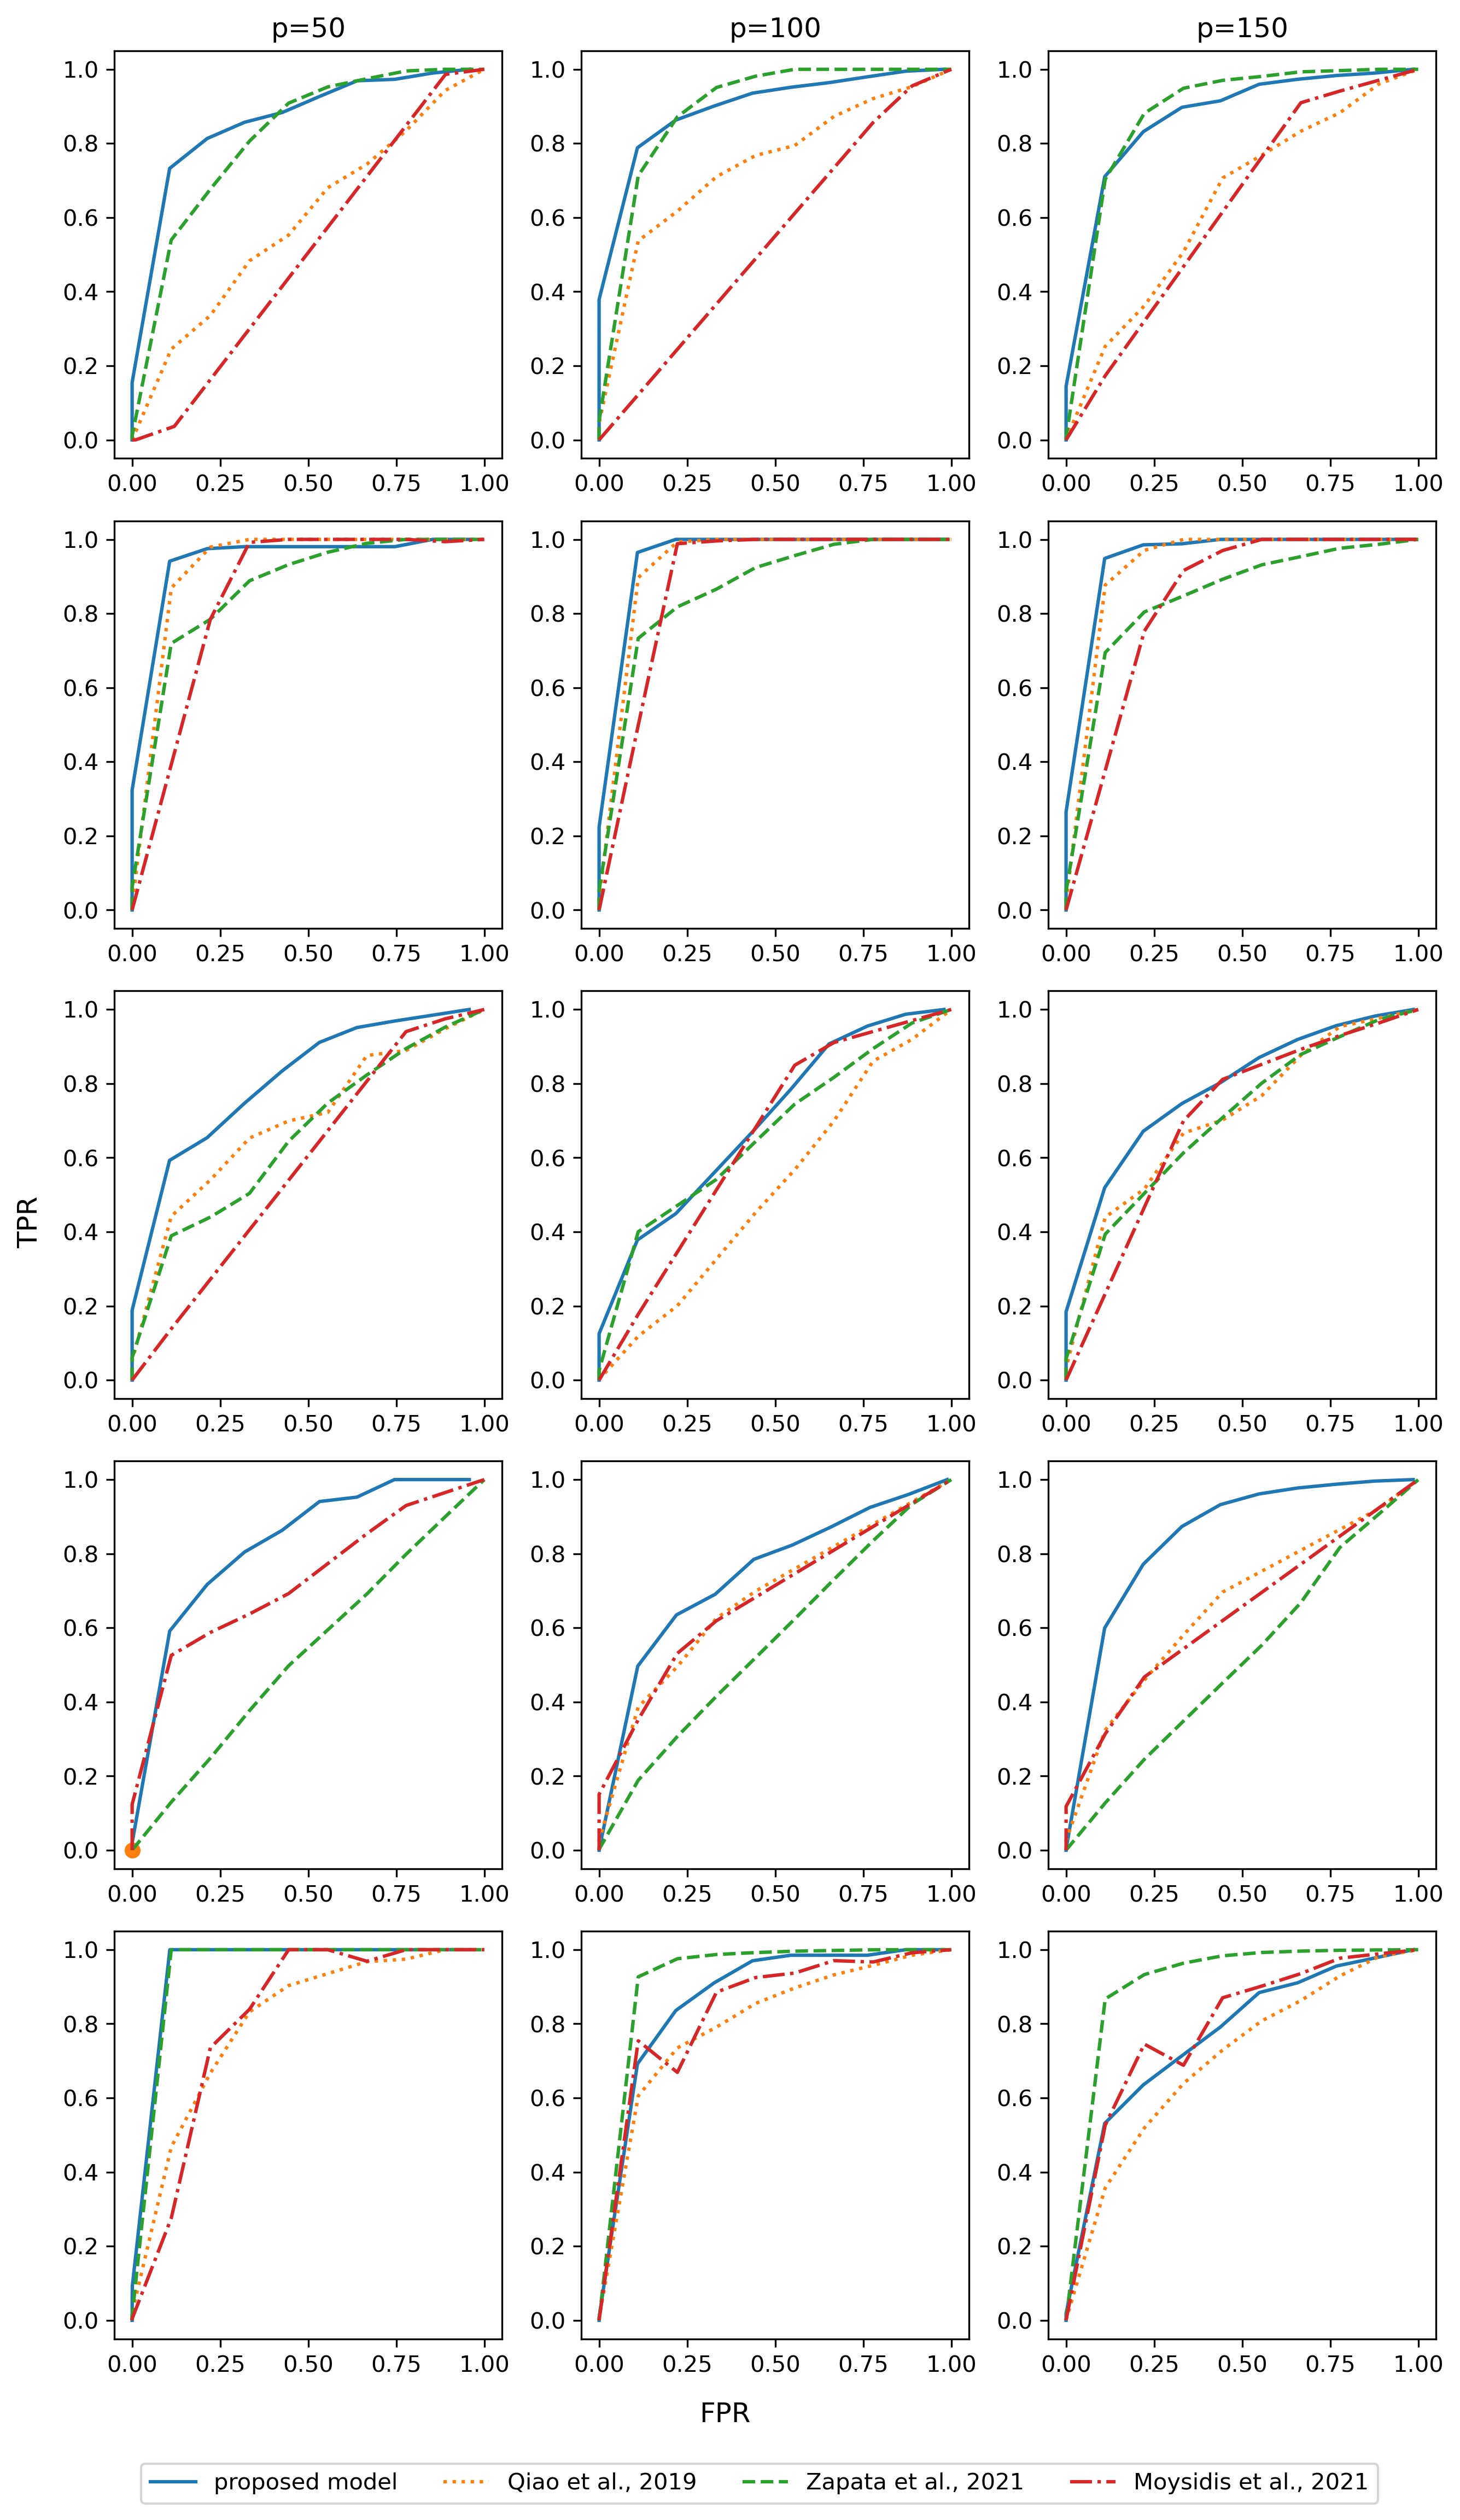

In [257]:
fig, axlist = plt.subplots(5,3,figsize=(9, 15), dpi=300)
model_path1 = "../../result_vision/old_result/results201/"
model_path = "../../result_intel/results20/"

comparison_path = "../../result_intel/results_c20/"

zapata_path= "../../result_intel/results_c20/"


plotplot(gid=1, axlist=axlist[0], graphname='tridiag1', noise_model='noise3_', N=100)
plotplot(gid=2, axlist=axlist[1], graphname='tridiag2', noise_model='noise3_', N=100)
plotplot(gid=3, axlist=axlist[2], graphname='tridiag3', noise_model='noise3_', N=100)
plotplot(gid=4, axlist=axlist[3], graphname='power', noise_model='noise3_', N=100)
plotplot(gid=5, axlist=axlist[4], graphname='random', noise_model='noise3_', N=100)

fig.supxlabel('FPR')
fig.supylabel('TPR')
fig.tight_layout()
#fig.savefig('../../images/roc/compare_id21'+'.png', bbox_inches='tight')


In [72]:

#file_list=['power_p150_N50', 'random_p150_N100', 'random_p150_N500']
linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
def plotN( axlist, graphname, noise_model, rate):
    file_list = list()
    p_list = [50,100,150]
    basefile = '{}'.format(graphname)
    for i in p_list:
        file_list.append(basefile+'_p{}'.format(i))
    
    #fig.suptitle('ROC curve of graph {}, N={}'.format(gid, N))
    i = 0
    for ax,filename in zip(axlist,file_list):
        j = 0
        for n,x in zip([50,100,200,500], rate[i]):
            p_file = model_path1+"model3_"+filename+"_N{}_Iest_".format(n) + noise_model +"thre0.001_rate{}_run8_tprfpr.npy".format(x)
            if not exists(p_file):
                p_file = model_path+"model3_"+filename+"_N{}_Iest_".format(n) + noise_model +"run8_thre1000_tprfpr.npy"
            if not exists(p_file):
                p_file = model_path+"model3_"+filename+"_N{}_Iest_".format(n) + noise_model +"run7_tprfpr.npy"

            arr = np.load(p_file)
            sort_fpr = np.argsort(arr[:,1])

            flng = np.zeros(arr.shape)
            flng[:,0] = arr[sort_fpr,0]
            flng[:,1] = arr[sort_fpr,1]

            m = remove_duplicate(flng[:,1], flng[:,0])

            if m.shape[0]<=4:
                ax.step(m[:,0], m[:,1], '-o', where='post', label="proposed model")
            else:
                p_fpr, p_tpr= drop_intermediate(m[:,0],m[:,1])
                X_Y_Spline = make_interp_spline(p_fpr, p_tpr, k=1)
                X_ = np.linspace(np.min(p_fpr), np.max(p_fpr), 10)
                Y_ = X_Y_Spline(X_)
                #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle=linestyles[j], label="N={}".format(n))
            j += 1
        i+=1
        ax.legend()


        


    #print(labels)

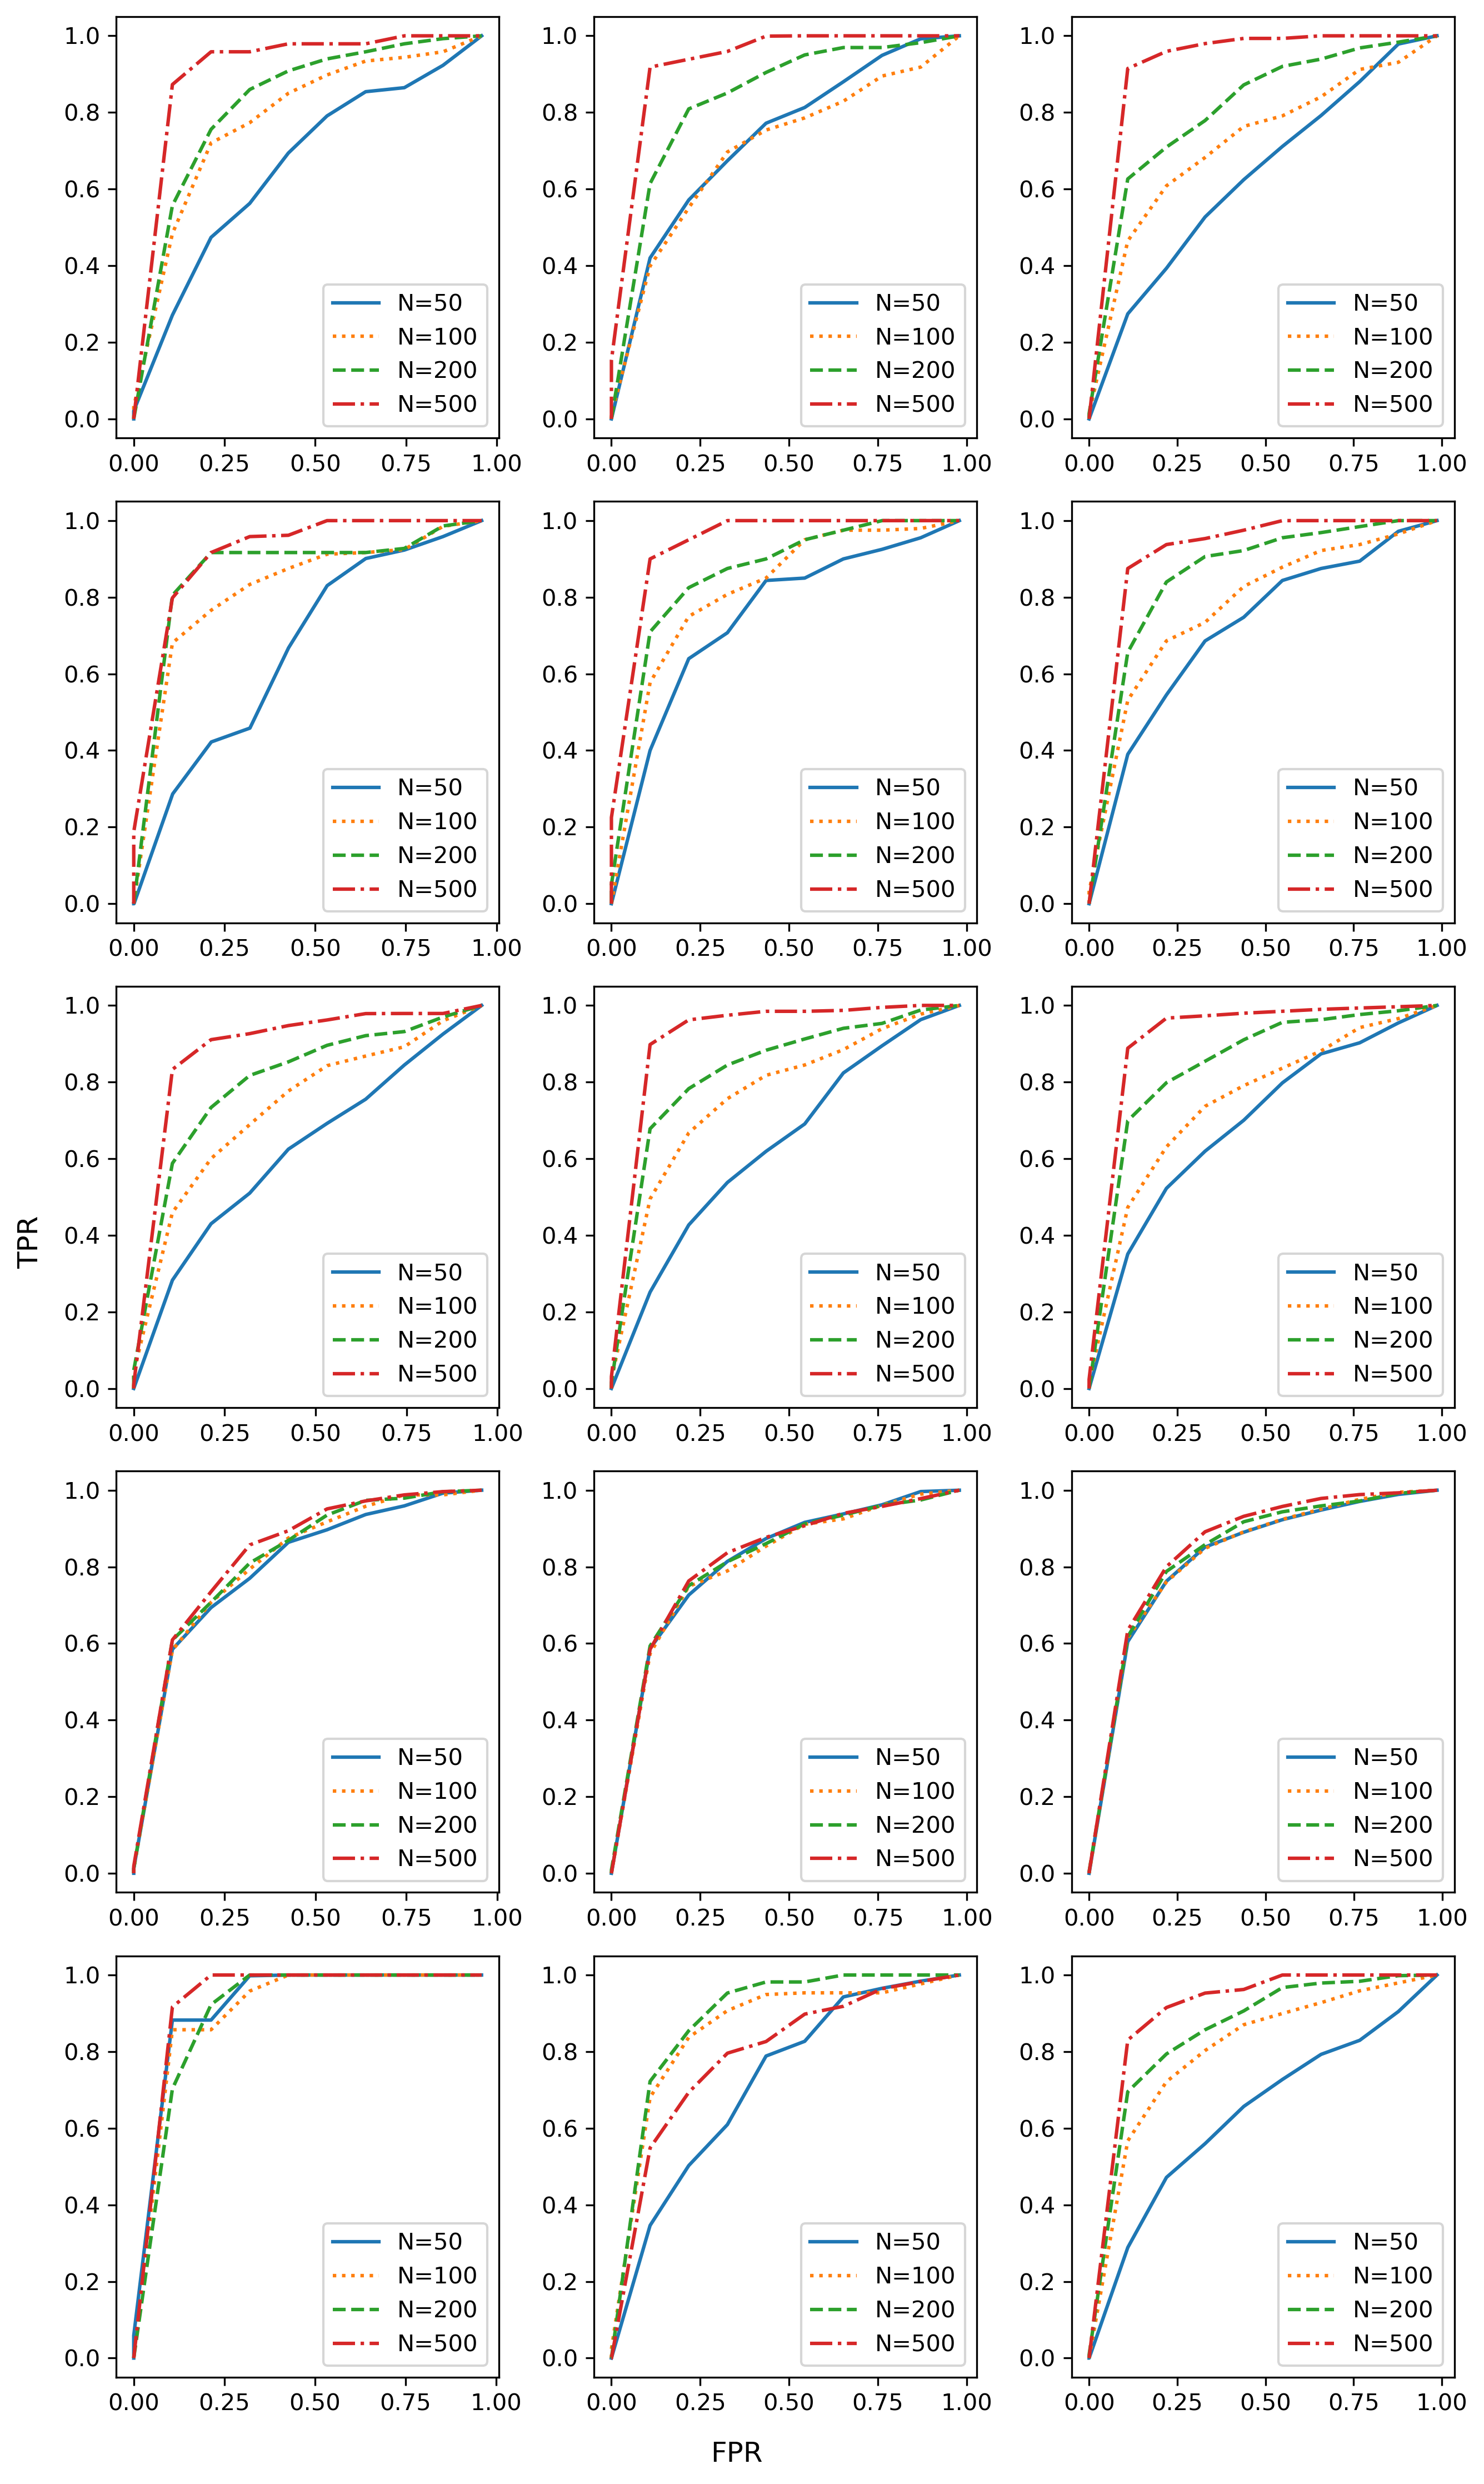

In [73]:
fig, axlist = plt.subplots(5,3,figsize=(9, 15), dpi=300)
model_path1 = "../../result_intel/results5/"
model_path = "../../result_intel/results5/"


plotN(axlist=axlist[0], graphname='tridiag1', noise_model='', rate=[[342,322,322,322], [322,322,322,322], [322,322,322,322]])
plotN(axlist=axlist[1], graphname='tridiag2', noise_model='', rate=[[332,332,332,332], [332,332,332,332], [332,332,332,332]])
plotN(axlist=axlist[2], graphname='tridiag3', noise_model='', rate=[[342,322,322,322], [322,322,322,322], [322,322,322,322]])
plotN(axlist=axlist[3], graphname='power',    noise_model='', rate=[[432,432,432,432], [432,432,432,432], [432,432,432,432]])
plotN(axlist=axlist[4], graphname='random',   noise_model='', rate=[[332,332,332,332], [332,332,332,332], [332,332,332,332]])

fig.supxlabel('FPR')
fig.supylabel('TPR')
fig.tight_layout()
fig.savefig('../../images/roc/compare_id5_samplesize'+'.png', bbox_inches='tight')


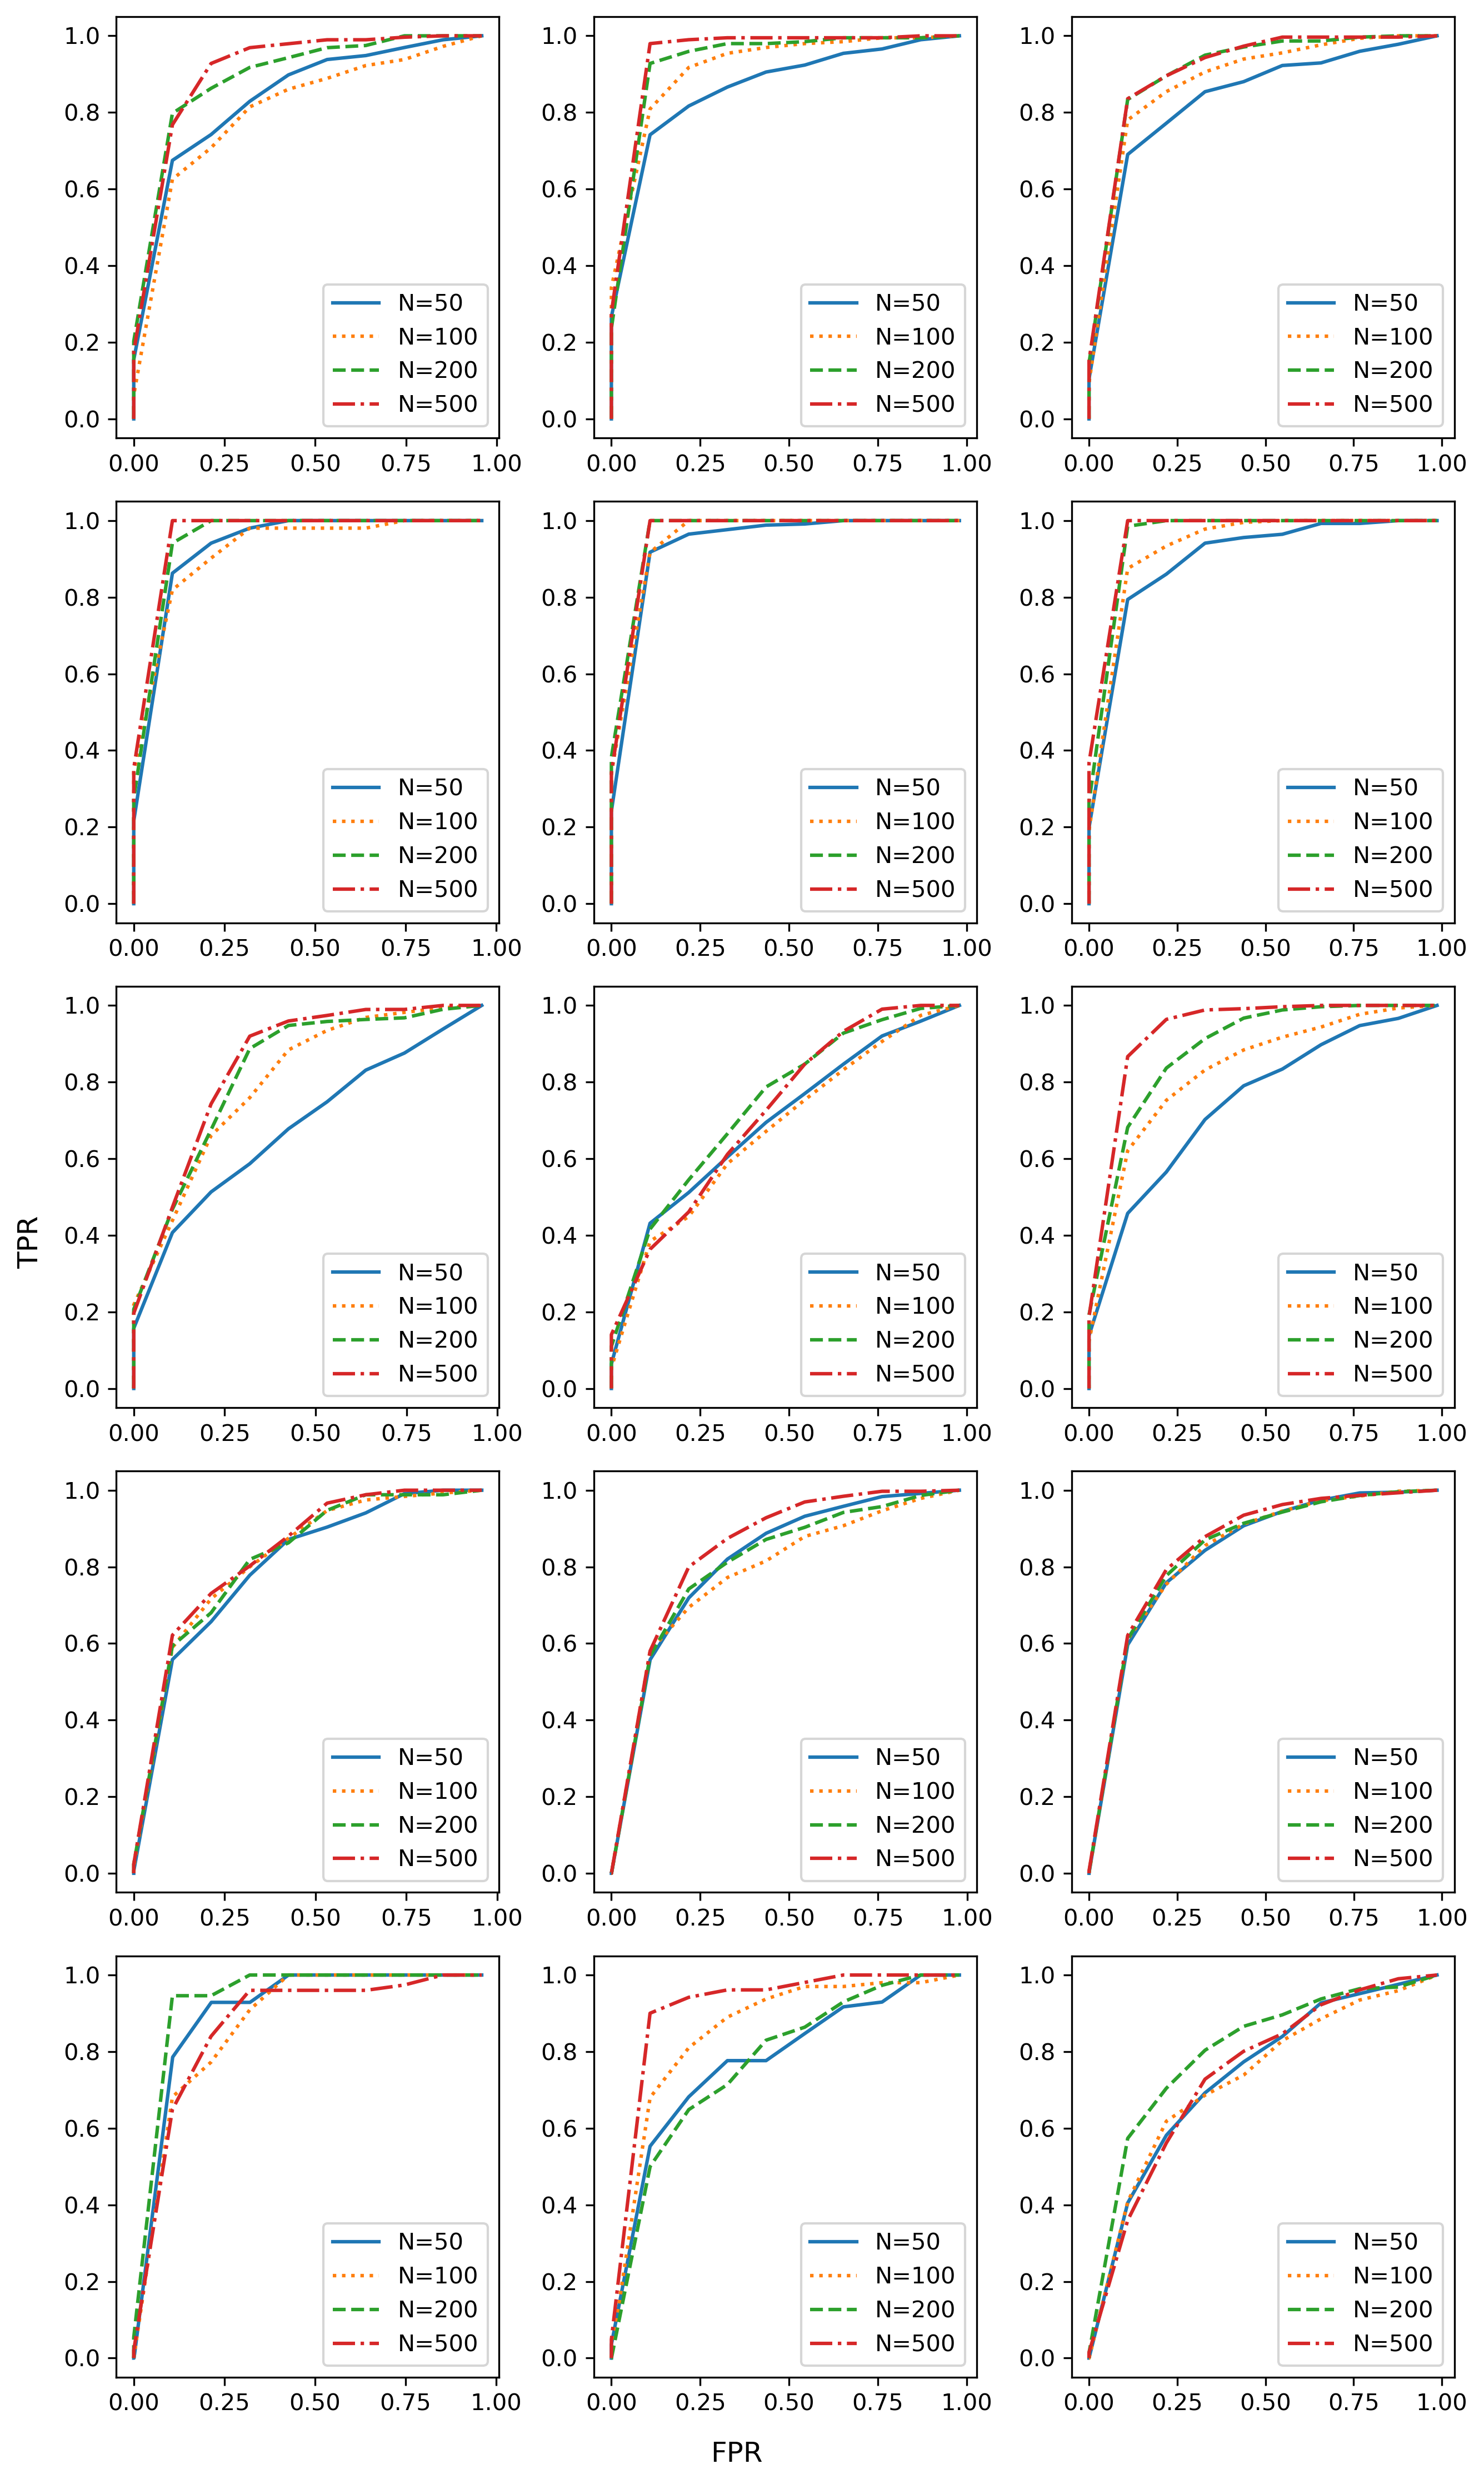

In [70]:
fig, axlist = plt.subplots(5,3,figsize=(9, 15), dpi=300)
model_path1 = "../../result_vision/old_result/results21/"
model_path = "../../result_intel/results21/"


plotN(axlist=axlist[0], graphname='tridiag1', noise_model='', rate=[[342,322,322,322], [322,322,322,322], [322,322,322,322]])
plotN(axlist=axlist[1], graphname='tridiag2', noise_model='', rate=[[332,332,332,332], [332,332,332,332], [332,332,332,332]])
plotN(axlist=axlist[2], graphname='tridiag3', noise_model='', rate=[[342,322,322,322], [322,322,322,322], [322,322,322,322]])
plotN(axlist=axlist[3], graphname='power',    noise_model='', rate=[[432,432,432,432], [432,432,432,432], [432,432,432,432]])
plotN(axlist=axlist[4], graphname='random',   noise_model='', rate=[[332,332,332,332], [332,332,332,332], [332,332,332,332]])

fig.supxlabel('FPR')
fig.supylabel('TPR')
fig.tight_layout()
fig.savefig('../../images/roc/compare_id21_samplesize'+'.png', bbox_inches='tight')


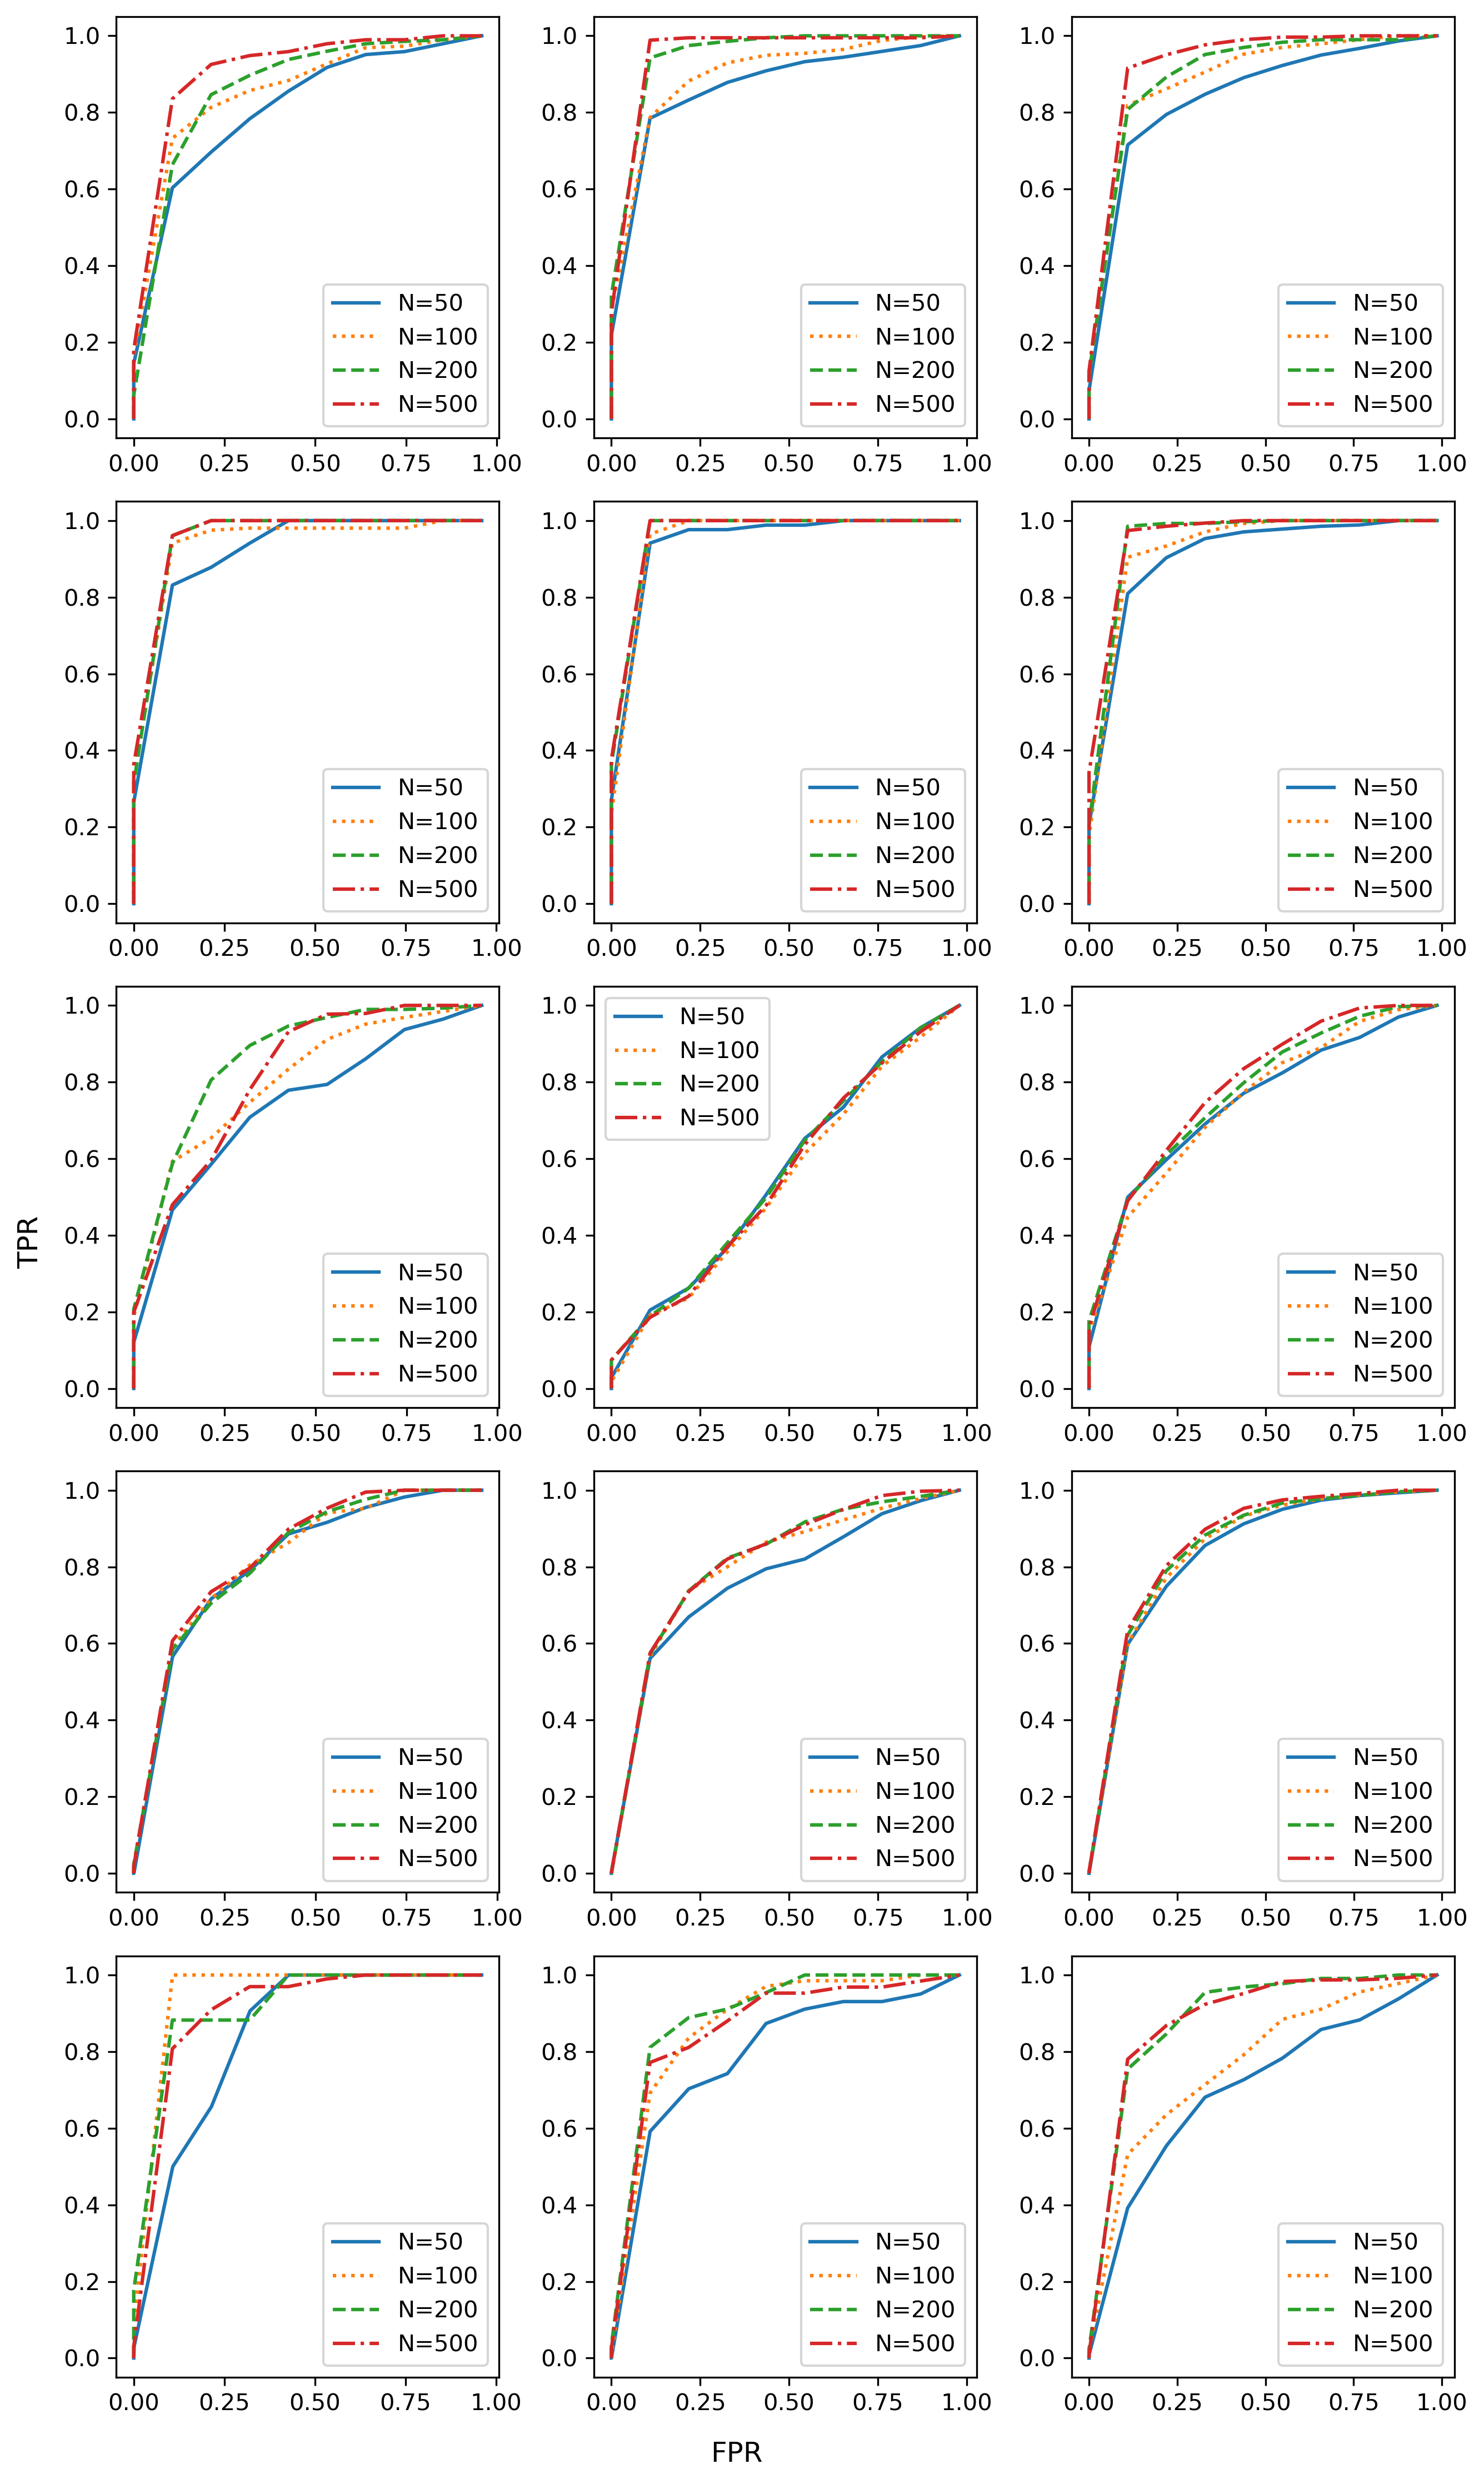

In [71]:
fig, axlist = plt.subplots(5,3,figsize=(9, 15), dpi=300)
model_path1 = "../../result_vision/old_result/results20/"
model_path = "../../result_intel/results20/"


plotN(axlist=axlist[0], graphname='tridiag1', noise_model='noise3_', rate=[[342,342,322,322], [322,322,322,322], [322,322,322,322]])
plotN(axlist=axlist[1], graphname='tridiag2', noise_model='noise3_', rate=[[332,332,332,332], [332,332,332,332], [332,332,332,332]])
plotN(axlist=axlist[2], graphname='tridiag3', noise_model='noise3_', rate=[[332,332,332,332], [432,432,432,432], [342,432,432,432]])
plotN(axlist=axlist[3], graphname='power',    noise_model='noise3_', rate=[[332,332,332,332], [332,332,332,332], [332,332,332,332]])
plotN(axlist=axlist[4], graphname='random',   noise_model='noise3_', rate=[[332,332,332,332], [332,332,332,332], [3,3,3,3]])

fig.supxlabel('FPR')
fig.supylabel('TPR')
fig.tight_layout()
fig.savefig('../../images/roc/compare_id20_samplesize'+'.png', bbox_inches='tight')


In [90]:

#file_list=['power_p150_N50', 'random_p150_N100', 'random_p150_N500']
def plotplot_lr(gid, graphname, N):
    file_list = list()
    p_list = [50,100, 150]
    basefile = '{}'.format(graphname)
    for i in p_list:

        file_list.append(basefile+'_p{}_N{}_Iest_noise3'.format(i, N))
    fig, axlist = plt.subplots(1,3,figsize=(9, 3), dpi=300)
    fig.suptitle('ROC curve of graph {}, N={}'.format(gid, N))
    i = 1
    for ax,filename in zip(axlist,file_list):
        ax.title.set_text("p={}".format(p_list[i-1]))
        i+=1
        for thre in [132,232,322,332,333,342,432]:

            
            p_file = model_path+"model3_" + filename + '_thre0.001_rate{}_run8_tprfpr.npy'.format(thre)

            if(exists(p_file)):
                #print('load file',p_file)
                arr = np.load(p_file)
                sort_fpr = np.argsort(arr[:,1])

                flng = np.zeros(arr.shape)
                flng[:,0] = arr[sort_fpr,0]
                flng[:,1] = arr[sort_fpr,1]

                m = remove_duplicate(flng[:,1], flng[:,0])

                if m.shape[0]<=15:
                    ax.step(m[:,0], m[:,1], '-o', where='post', label= "N={}, rate={}".format(N,thre))
                else:
                    p_fpr, p_tpr= drop_intermediate(m[:,0],m[:,1])
                    X_Y_Spline = make_interp_spline(p_fpr, p_tpr, k=1)
                    X_ = np.linspace(np.min(p_fpr), np.max(p_fpr), 15)
                    Y_ = X_Y_Spline(X_)
                    #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
                    ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='solid', label= "N={}, rate{}".format(N,thre))
                
        if i == 2:
            handles, labels = ax.get_legend_handles_labels()
    if len(labels)==3:
        b = 0.85
    else:
        b = 0.95
    
    fig.legend(handles, labels, ncol=4, bbox_to_anchor=(b, -0.0))

    fig.supxlabel('FPR')
    fig.supylabel('TPR')
    fig.tight_layout()

    #print(labels)

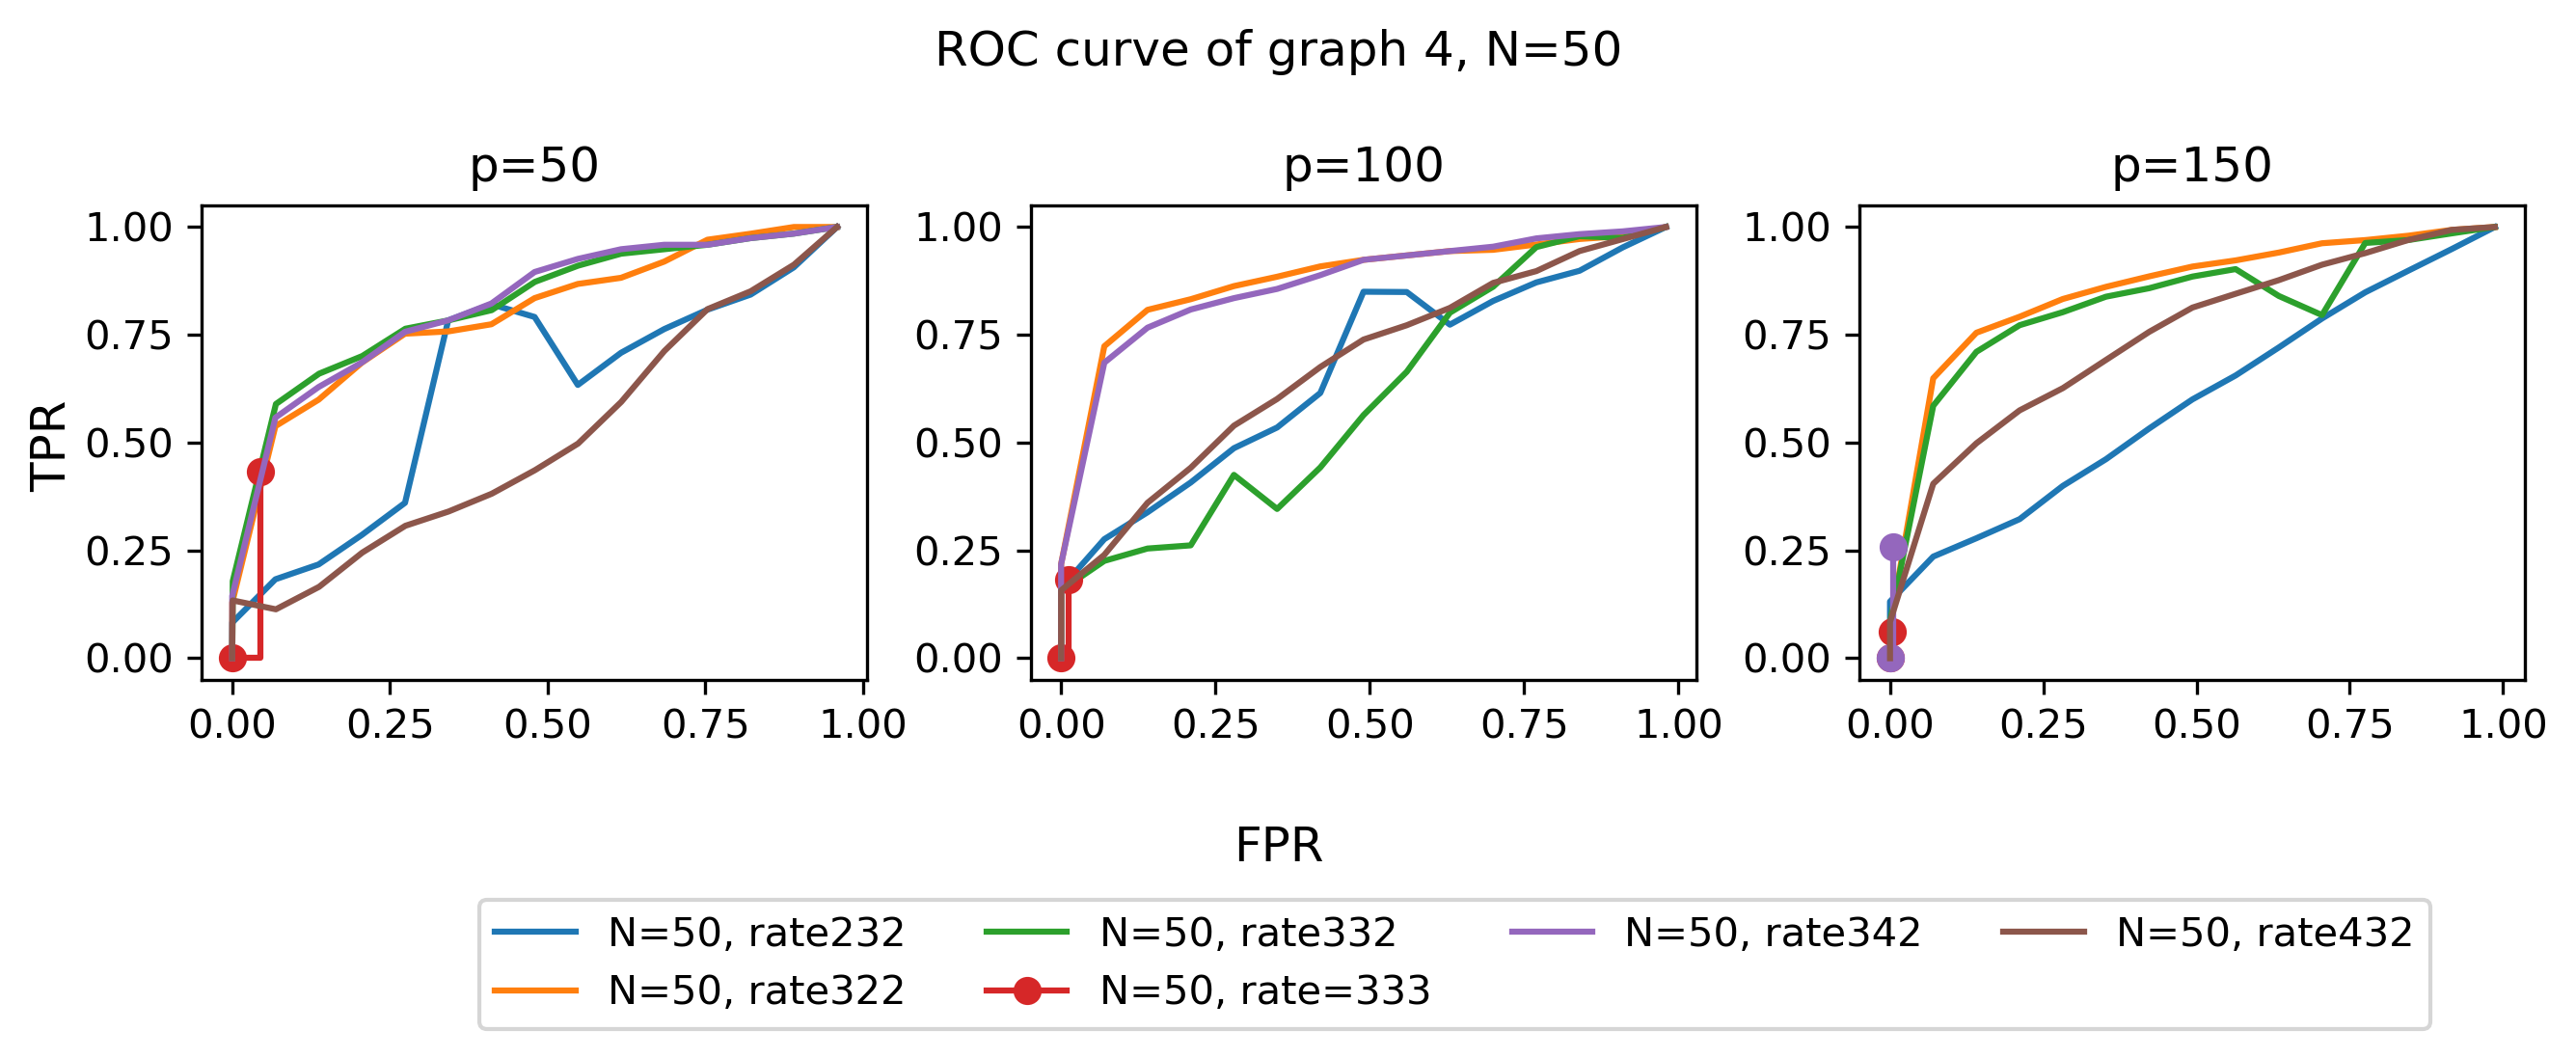

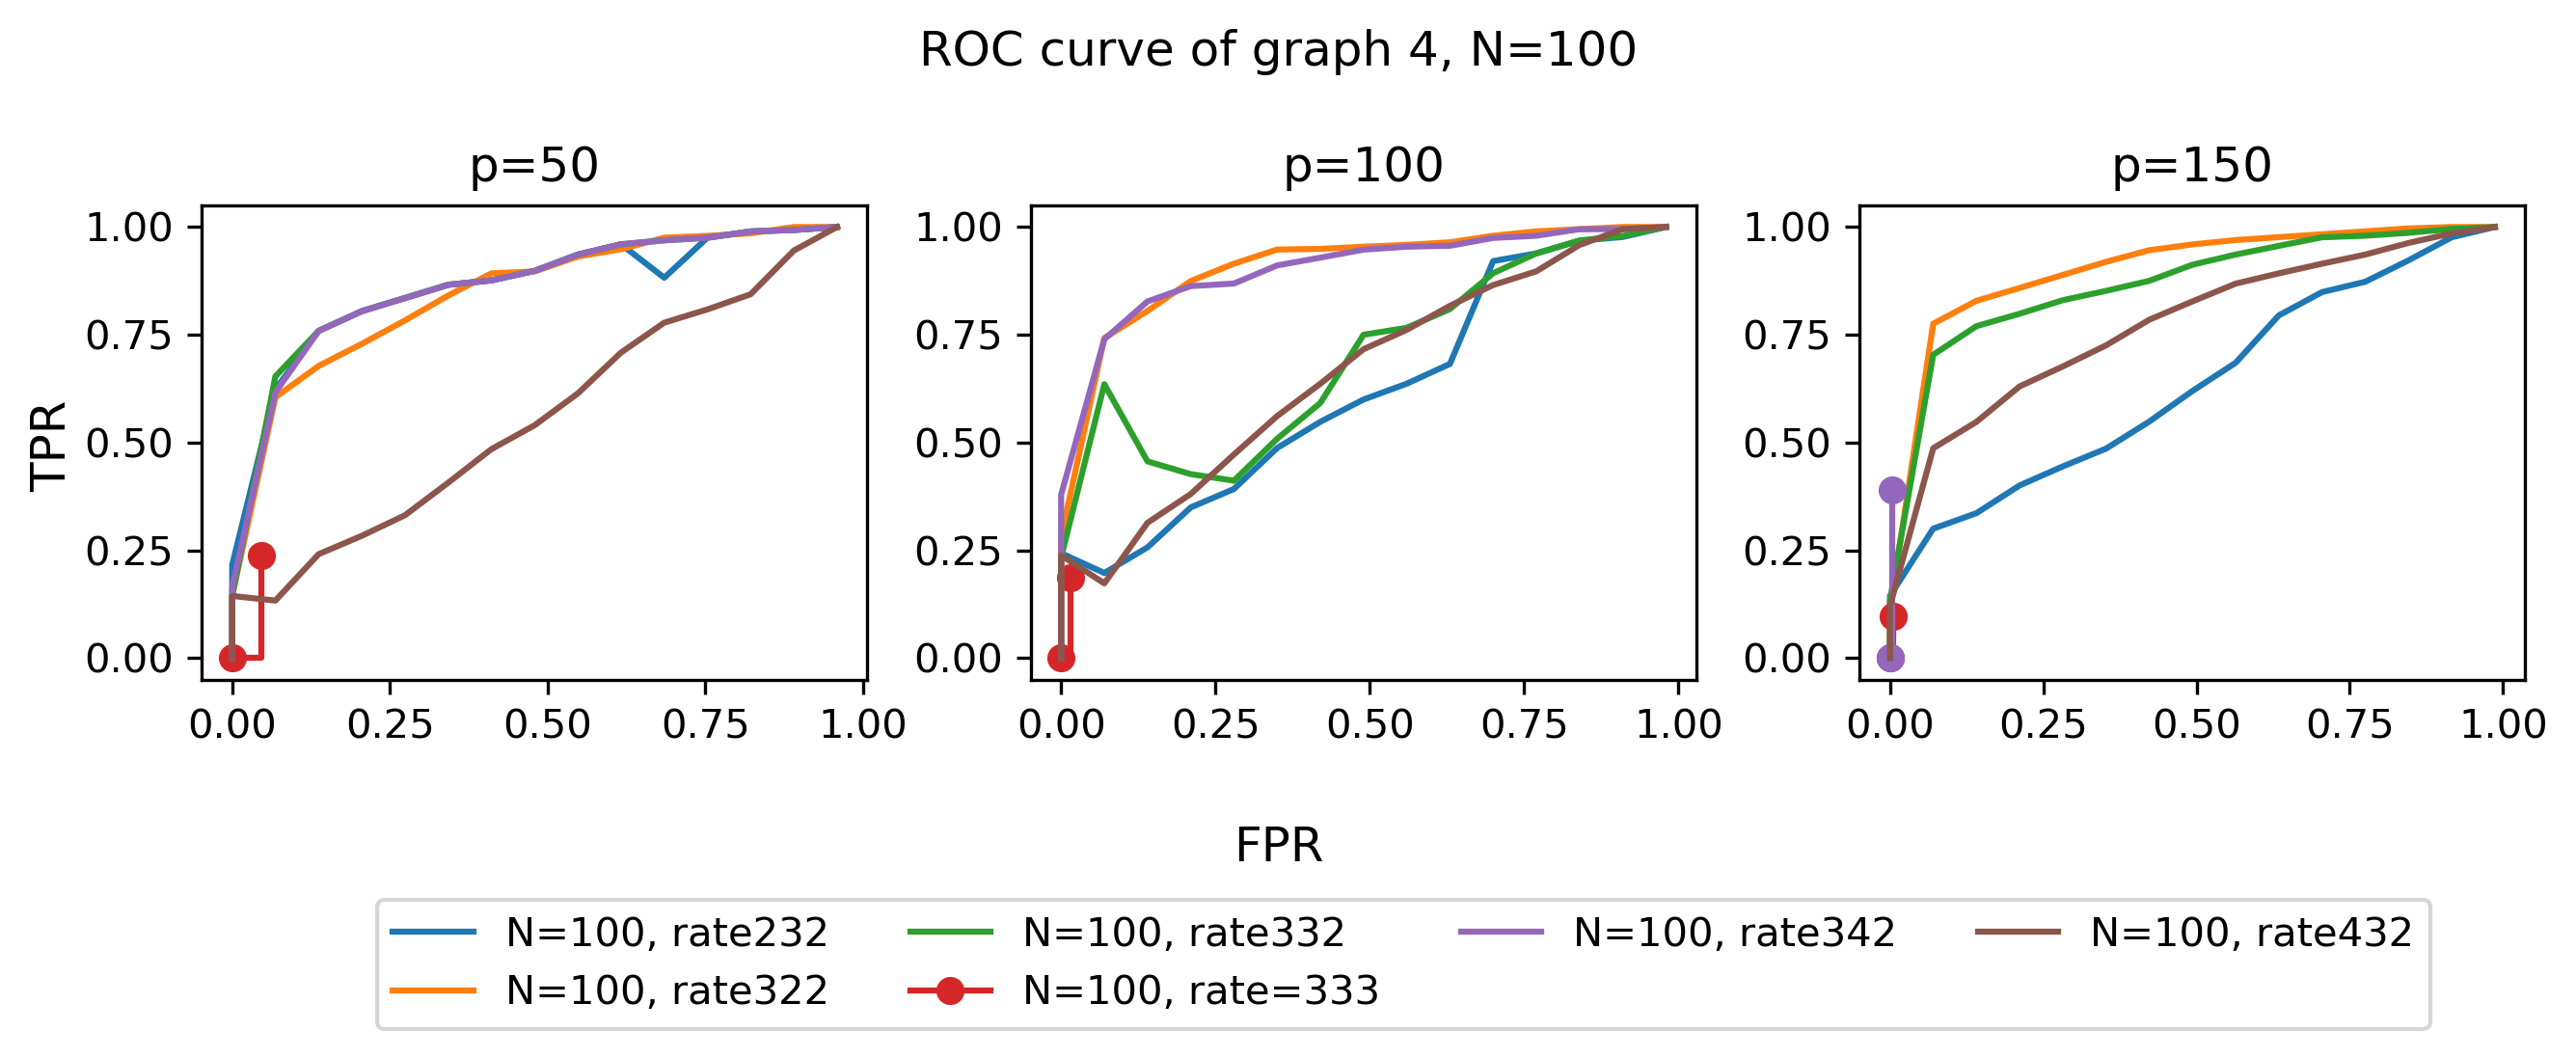

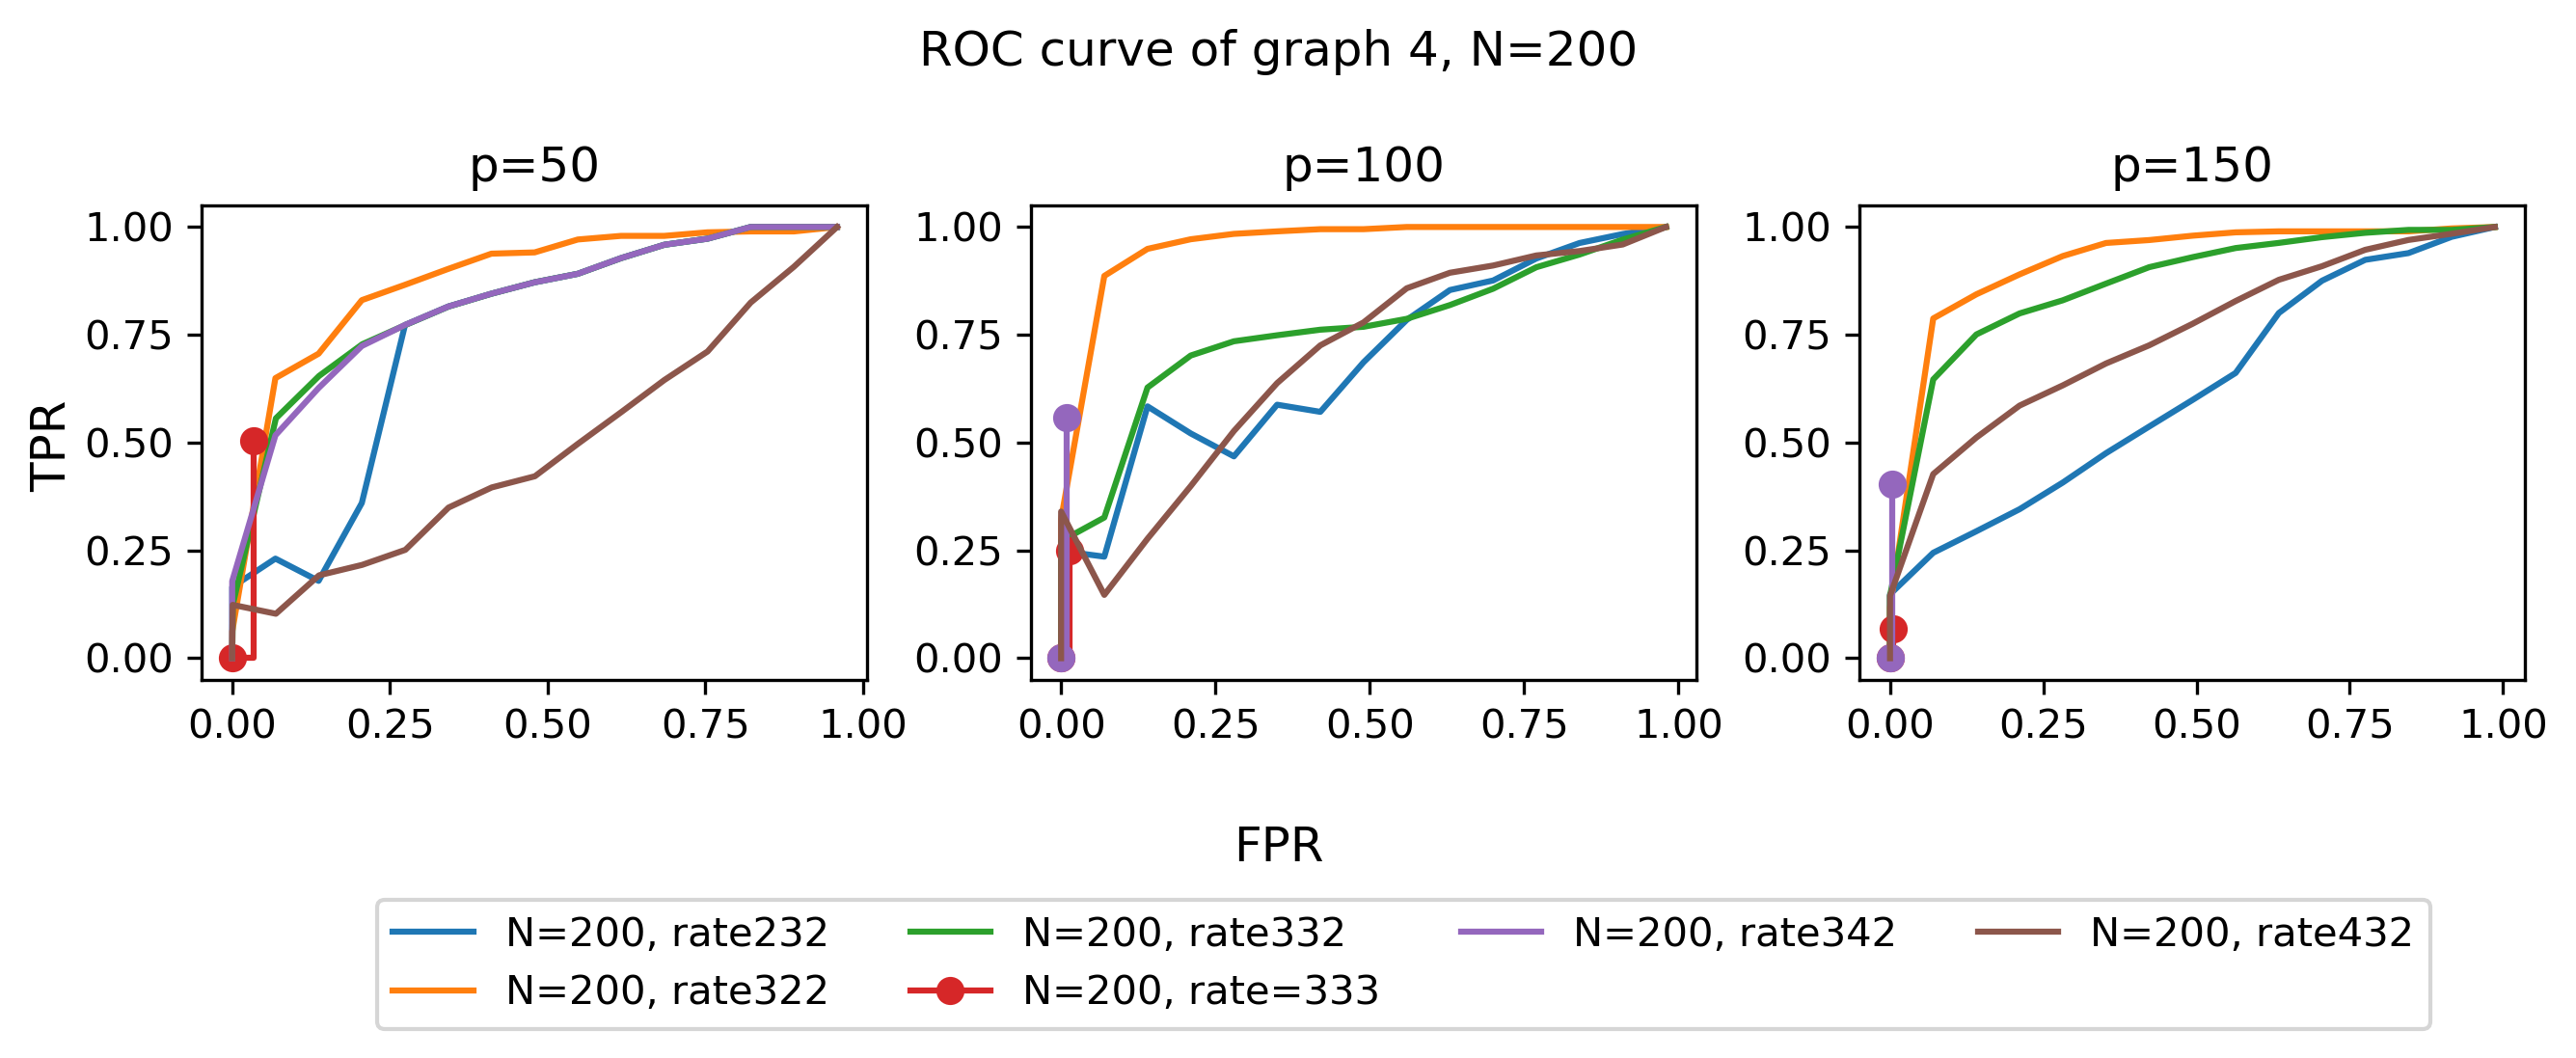

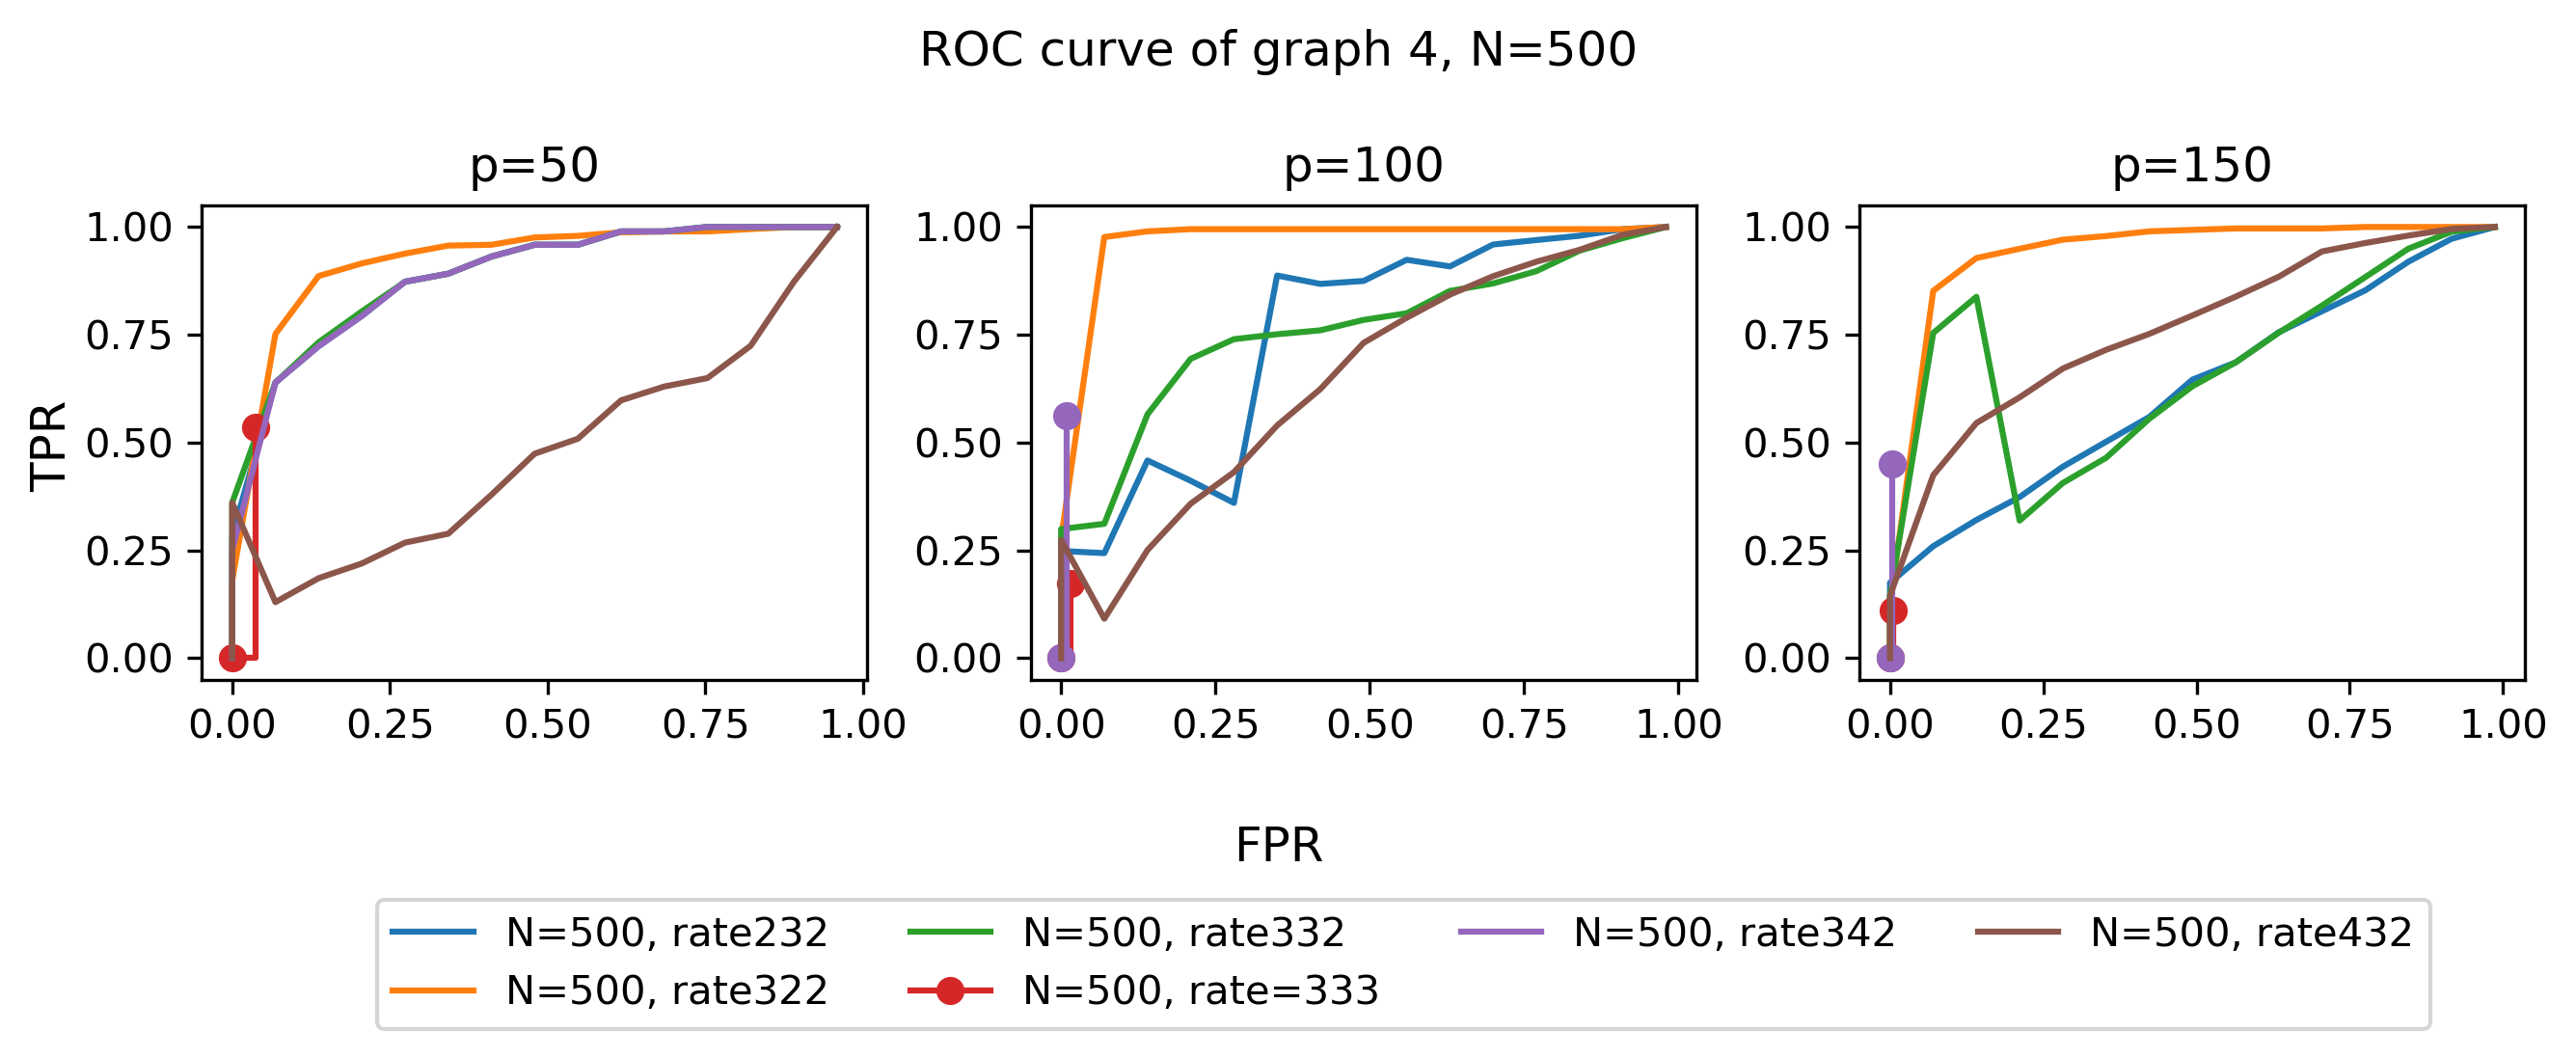

In [109]:
model_path = "../../result_vision/old_result/results20/"
test_model = 'tridiag1'
plotplot_lr(4, test_model, 50)
plotplot_lr(4, test_model, 100)
plotplot_lr(4, test_model, 200)
plotplot_lr(4, test_model, 500)

In [16]:

#file_list=['power_p150_N50', 'random_p150_N100', 'random_p150_N500']
def plotplot_proposed(gid, graphname, N):
    file_list = list()
    p_list = [50,100,150]
    basefile = '{}'.format(graphname)
    for i in p_list:

        file_list.append(basefile+'_p{}_N{}_Iest_noise3_run8'.format(i, N))
    fig, axlist = plt.subplots(1,3,figsize=(9, 3), dpi=300)
    fig.suptitle('ROC curve of graph {}, N={}'.format(gid, N))
    i = 1
    for ax,filename in zip(axlist,file_list):
        ax.title.set_text("p={}".format(p_list[i-1]))
        i+=1
        for thre in [10, 100, 1000]:

            
            p_file = model_path+"model3_" + filename + '_thre{}_tprfpr.npy'.format(thre)

        
            arr = np.load(p_file)
            sort_fpr = np.argsort(arr[:,1])

            flng = np.zeros(arr.shape)
            flng[:,0] = arr[sort_fpr,0]
            flng[:,1] = arr[sort_fpr,1]

            m = remove_duplicate(flng[:,1], flng[:,0])

            if m.shape[0]<=15:
                ax.step(m[:,0], m[:,1], '-o', where='post', label= "N={}, thre={}".format(N,1/thre))
            else:
                p_fpr, p_tpr= drop_intermediate(m[:,0],m[:,1])
                X_Y_Spline = make_interp_spline(p_fpr, p_tpr, k=1)
                X_ = np.linspace(np.min(p_fpr), np.max(p_fpr), 15)
                Y_ = X_Y_Spline(X_)
                #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='solid', label= "N={}, thre={}".format(N,1/thre))
            
        ax.legend()
        fig.supxlabel('FPR')
        fig.supylabel('TPR')
        fig.tight_layout()

    #print(labels)

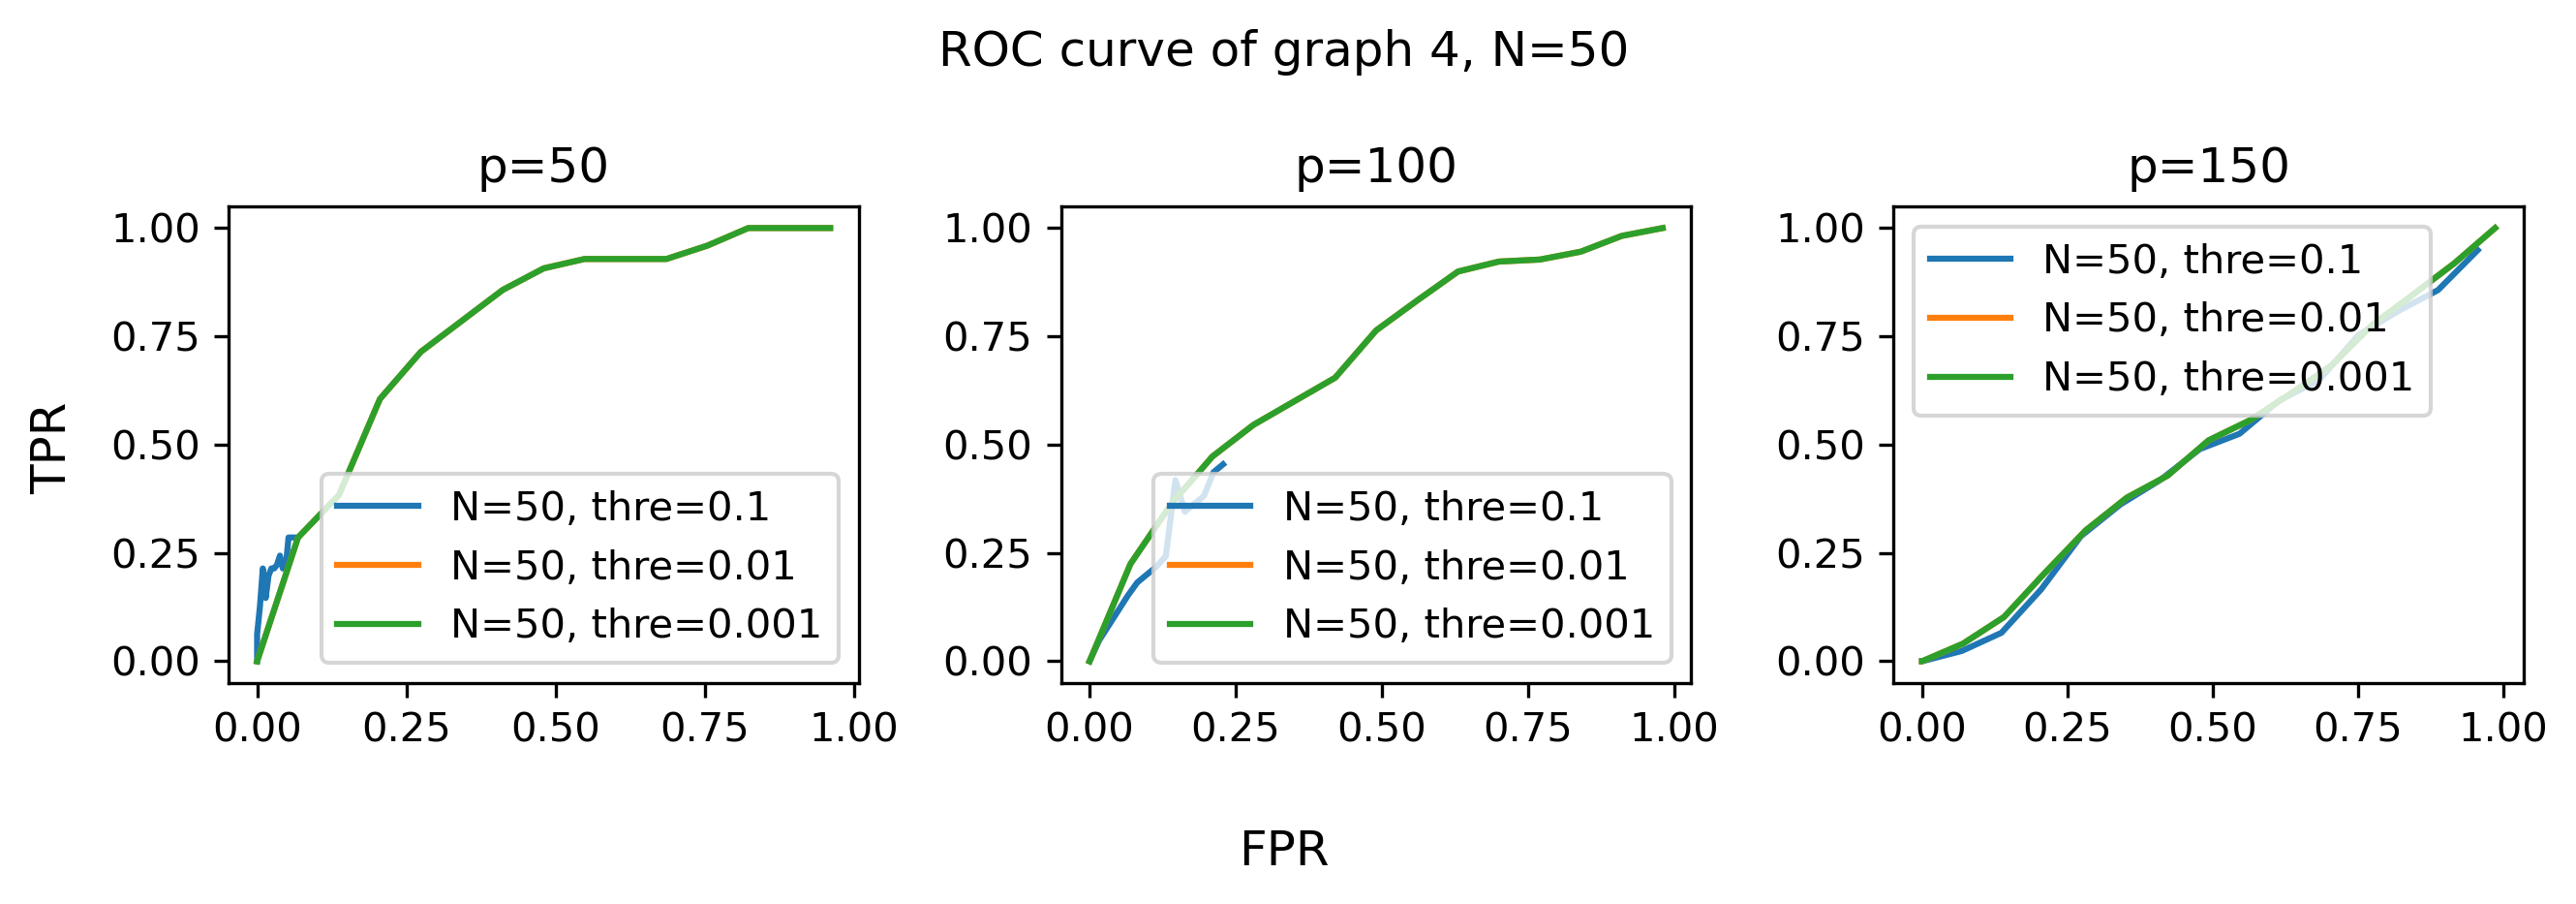

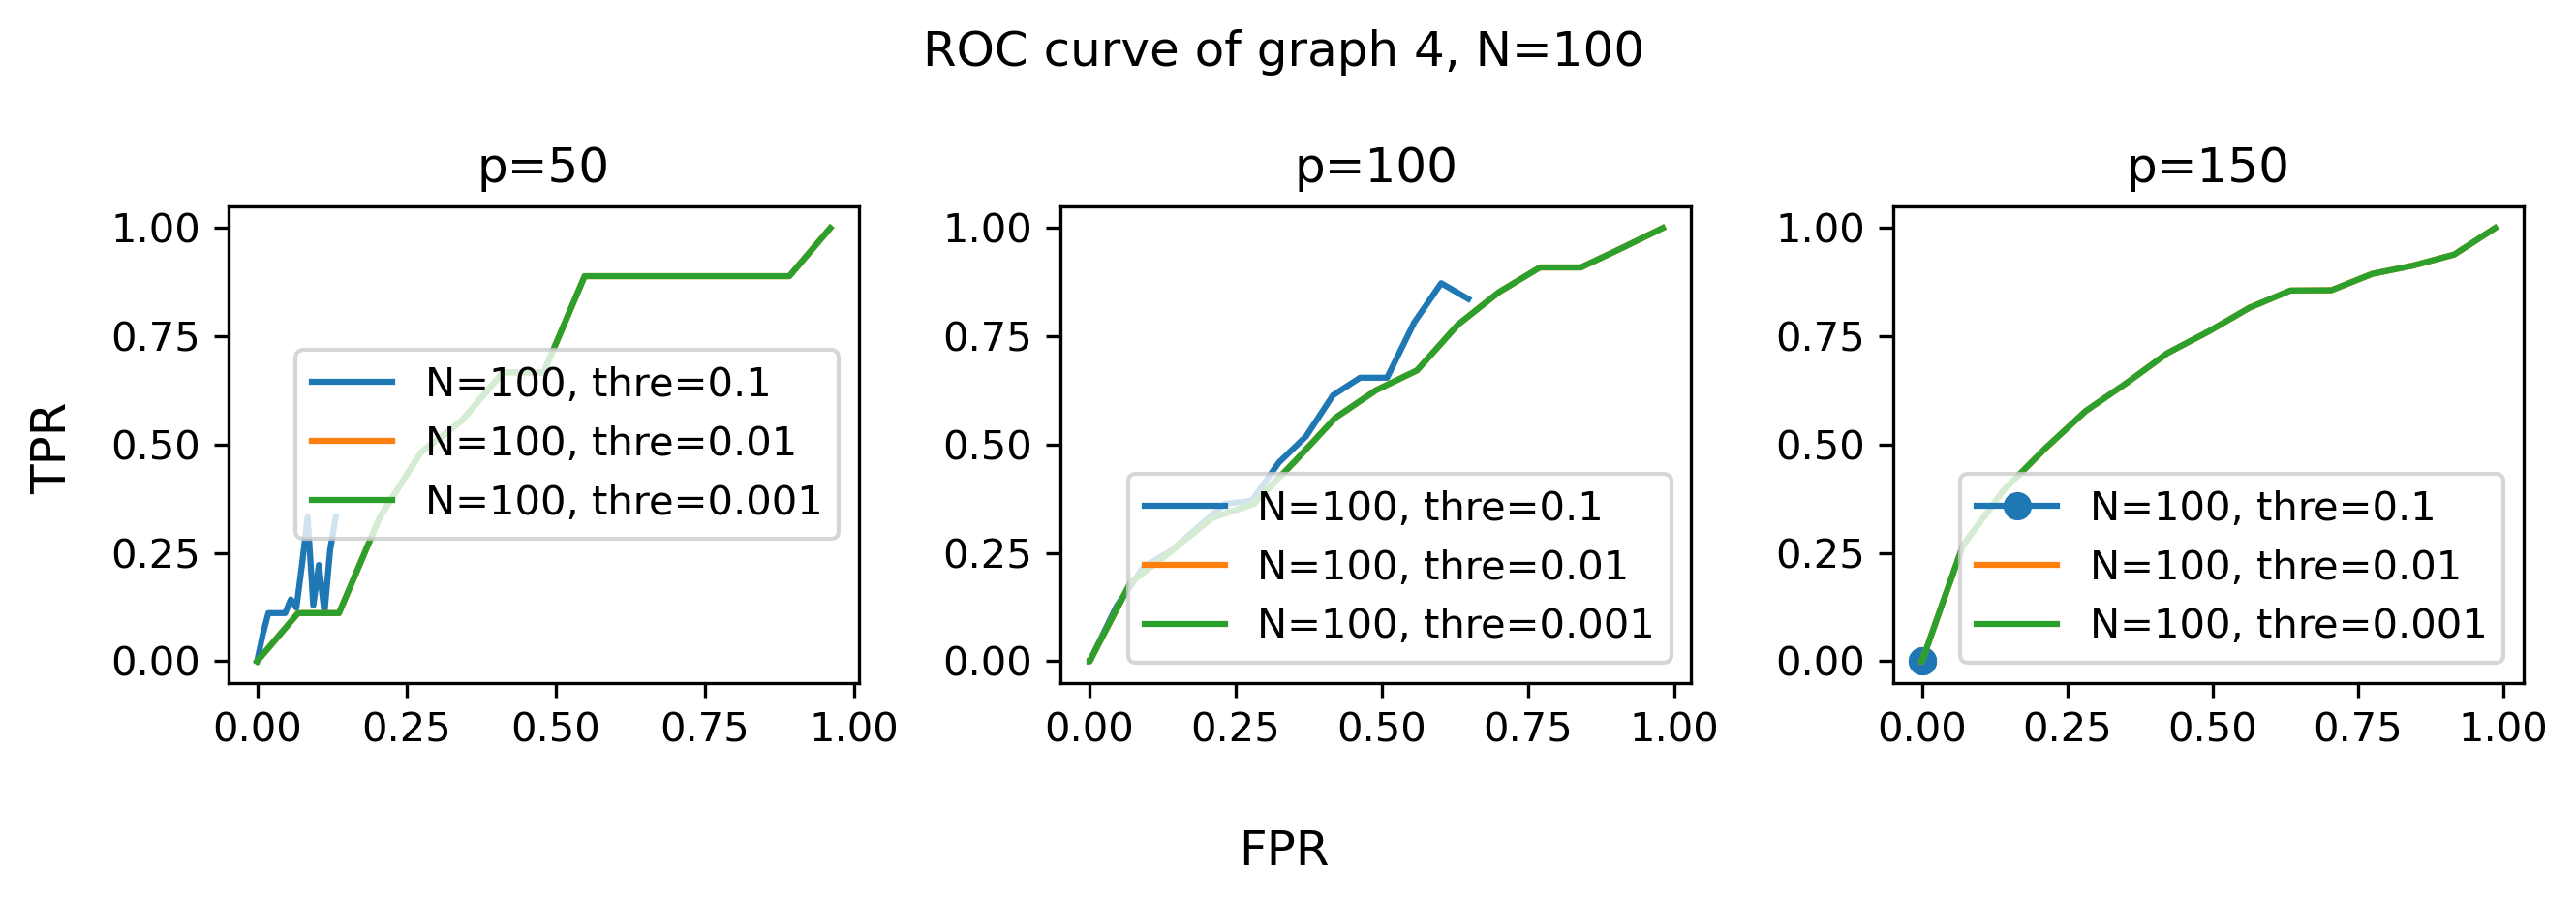

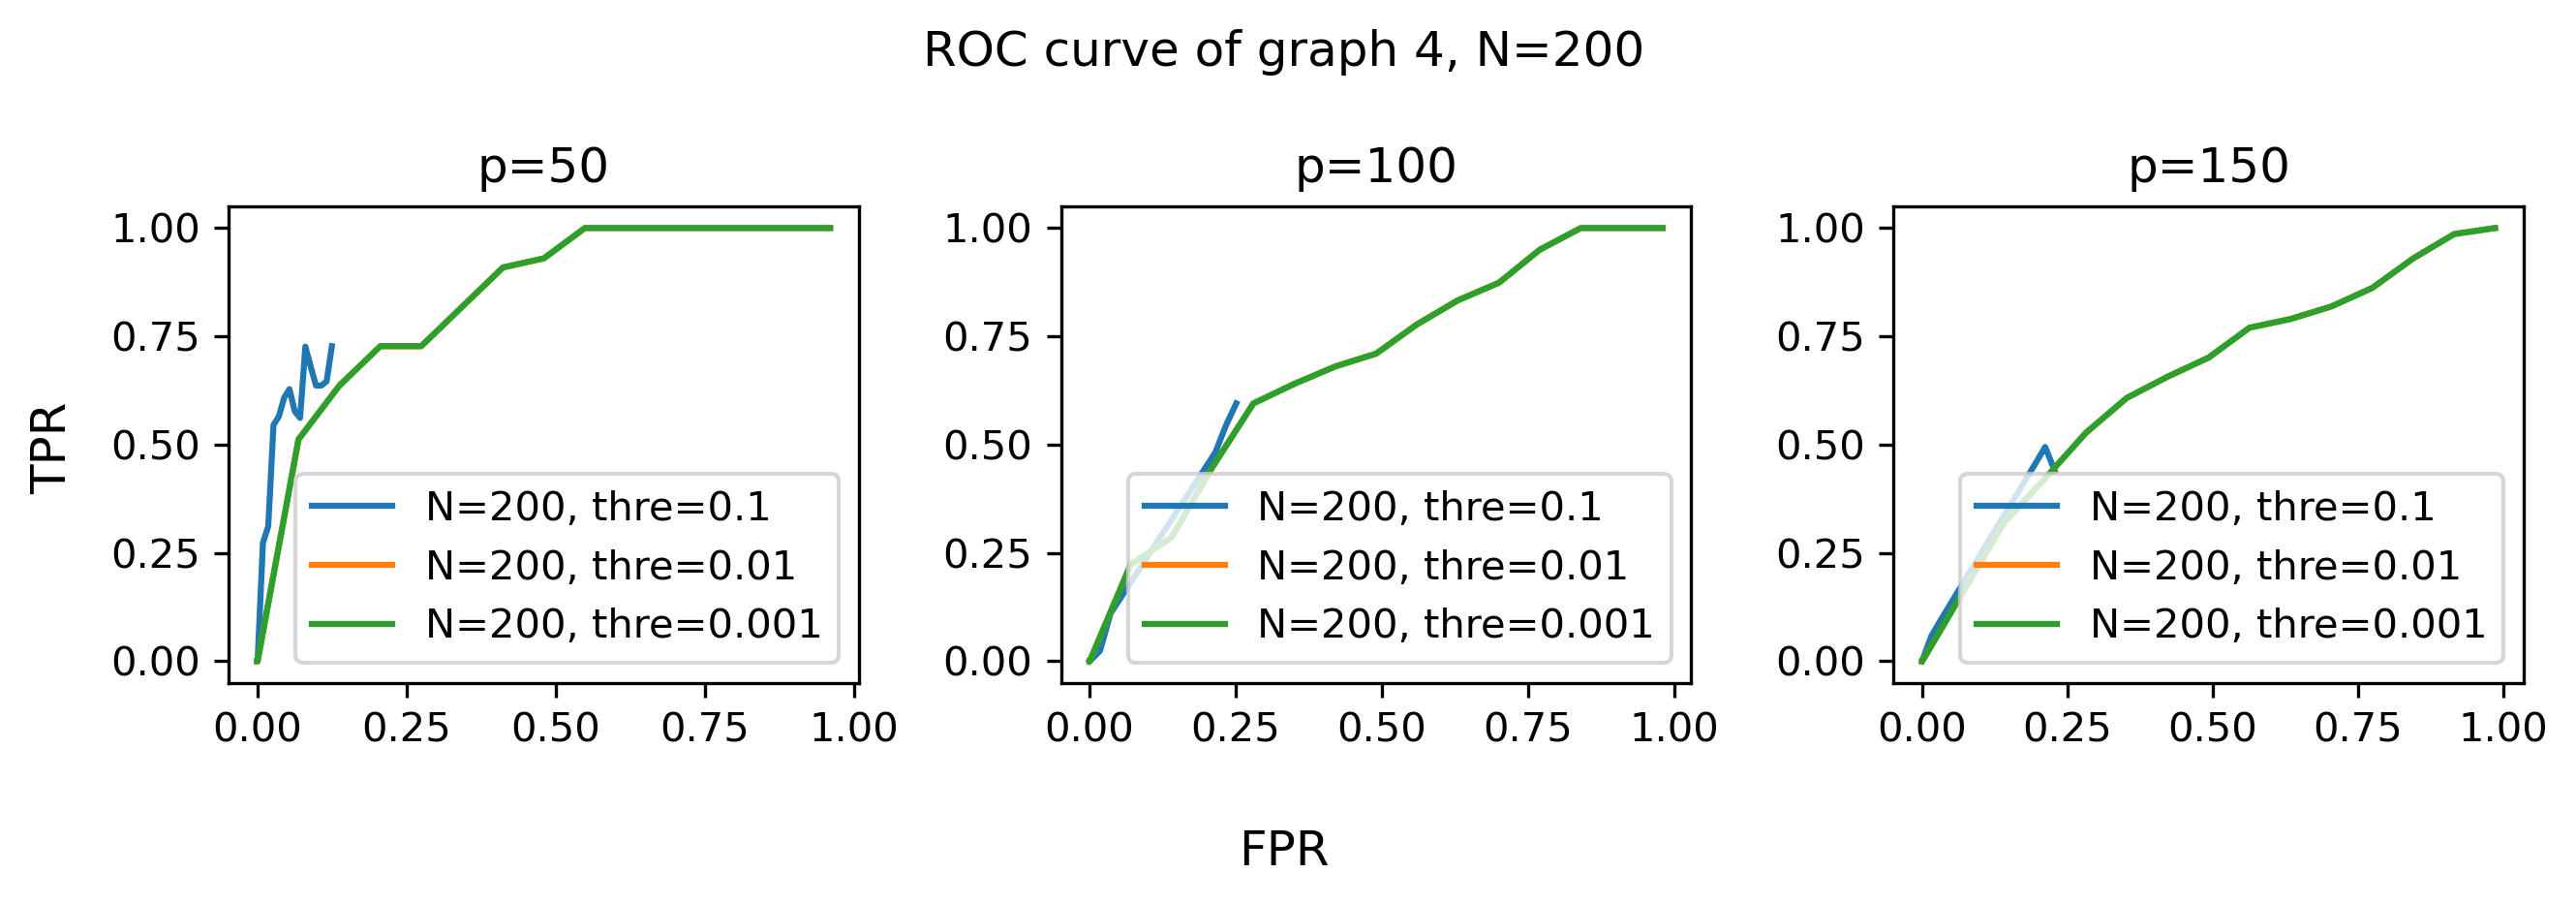

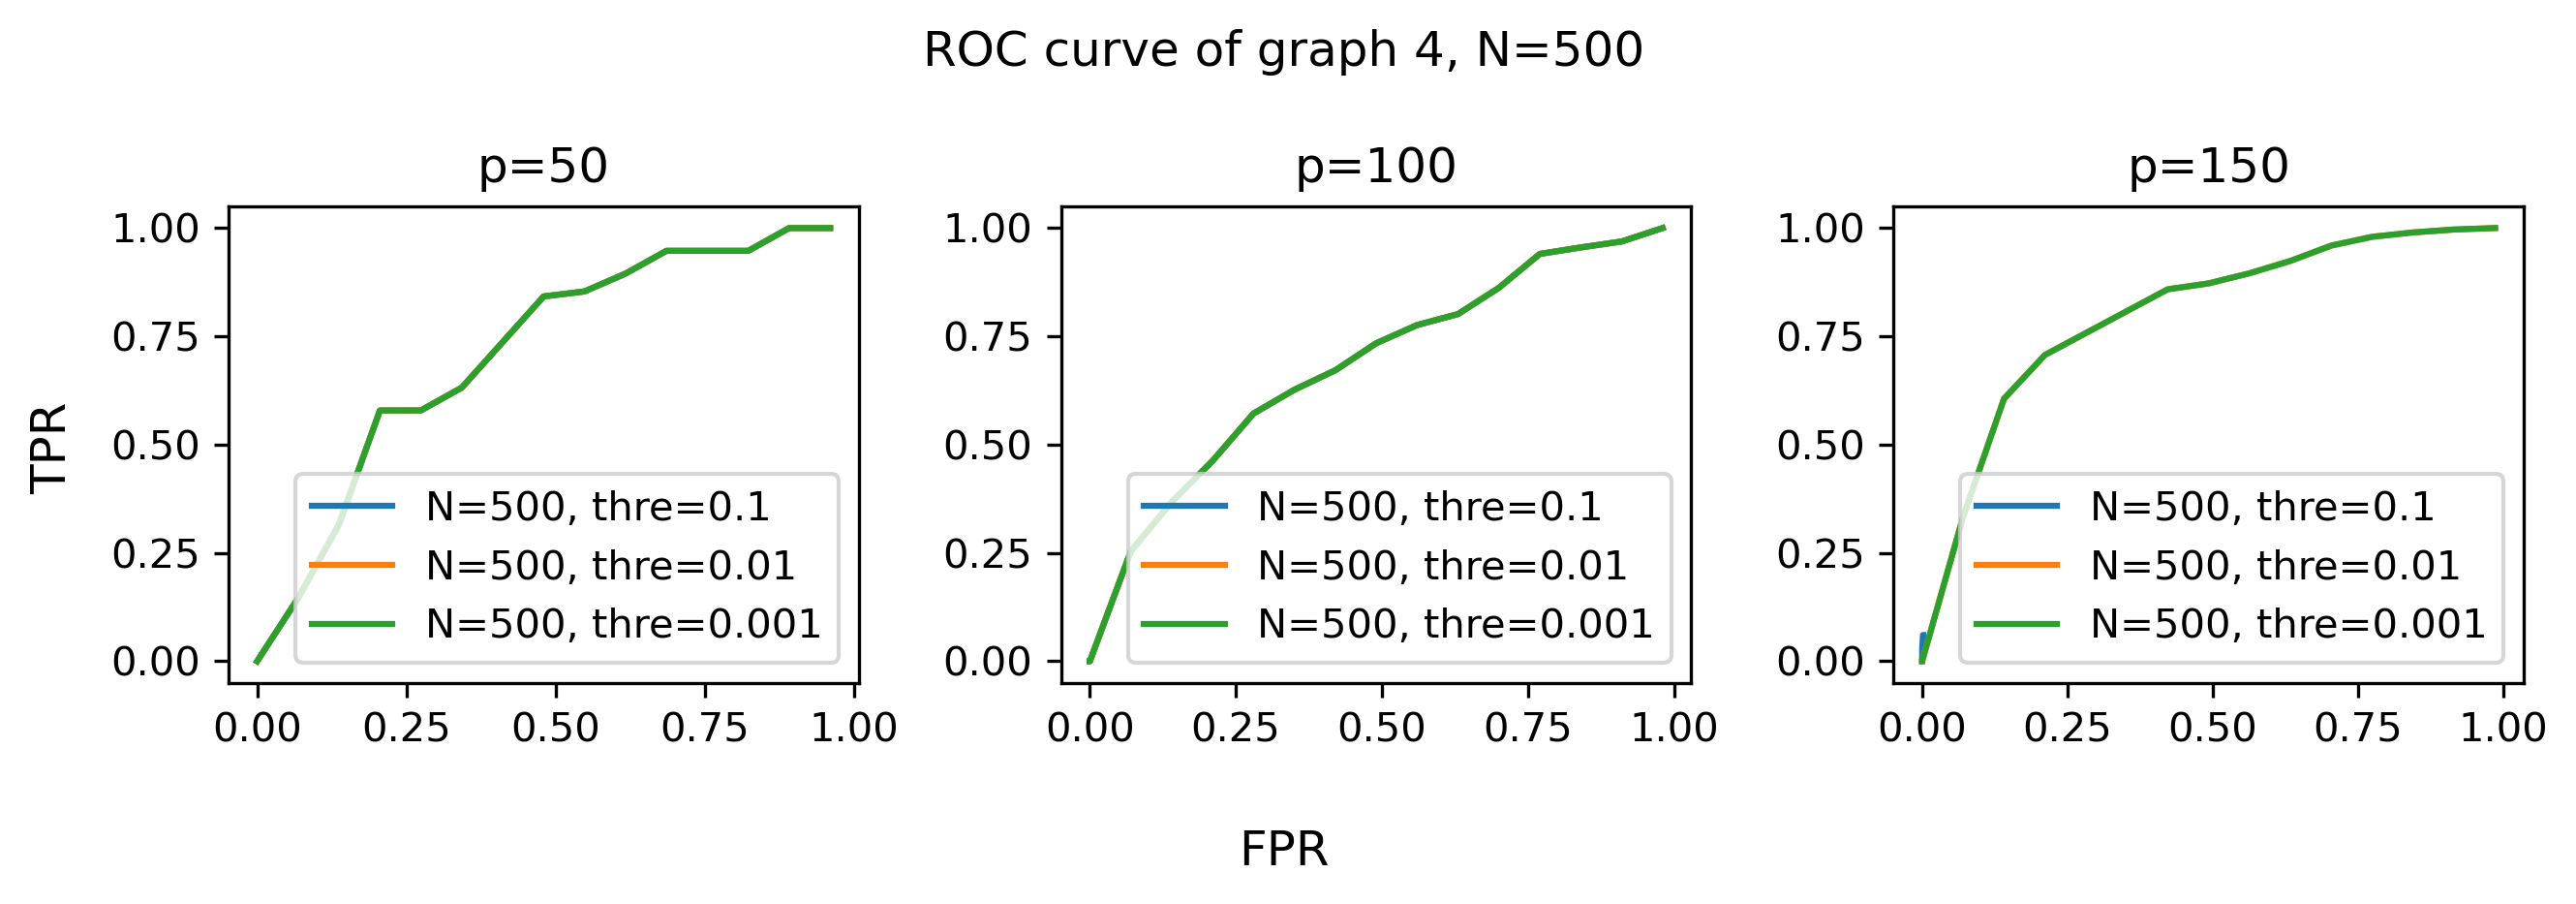

In [27]:
model_path = "../result_intel/results17/"
test_model = 'random'
plotplot_proposed(4, test_model, 50)
plotplot_proposed(4, test_model, 100)
plotplot_proposed(4, test_model, 200)
plotplot_proposed(4, test_model, 500)

In [44]:

#file_list=['power_p150_N50', 'random_p150_N100', 'random_p150_N500']
def plotplot_noise_level(gid, graphname, N, thre=100):
    file_list = list()
    p_list = [50,100,150]
    basefile = '{}'.format(graphname)
    for i in p_list:

        file_list.append(basefile+'_p{}_N{}_Iest_noise3_run8'.format(i, N))
    fig, axlist = plt.subplots(1,3,figsize=(9, 3), dpi=300)
    fig.suptitle('ROC curve of graph {}, N={}'.format(gid, N))
    i = 1
    model_paths = [
        "../result_intel/results16/",
        "../result_intel/results17/",
        "../result_intel/results18/"
    ]
    for ax,filename in zip(axlist,file_list):
        ax.title.set_text("p={}".format(p_list[i-1]))
        i+=1
        for model_path in model_paths:

            
            p_file = model_path+"model3_" + filename + '_thre{}_tprfpr.npy'.format(thre)

        
            arr = np.load(p_file)
            sort_fpr = np.argsort(arr[:,1])

            flng = np.zeros(arr.shape)
            flng[:,0] = arr[sort_fpr,0]
            flng[:,1] = arr[sort_fpr,1]

            m = remove_duplicate(flng[:,1], flng[:,0])

            if m.shape[0]<=15:
                ax.step(m[:,0], m[:,1], '-o', where='post', label= "N={}".format(N))
            else:
                p_fpr, p_tpr= drop_intermediate(m[:,0],m[:,1])
                X_Y_Spline = make_interp_spline(p_fpr, p_tpr, k=1)
                X_ = np.linspace(np.min(p_fpr), np.max(p_fpr), 15)
                Y_ = X_Y_Spline(X_)
                #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
                ax.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='solid',  label= "N={}".format(N))
            
        ax.legend()
        fig.supxlabel('FPR')
        fig.supylabel('TPR')
        #fig.tight_layout()

    #print(labels)

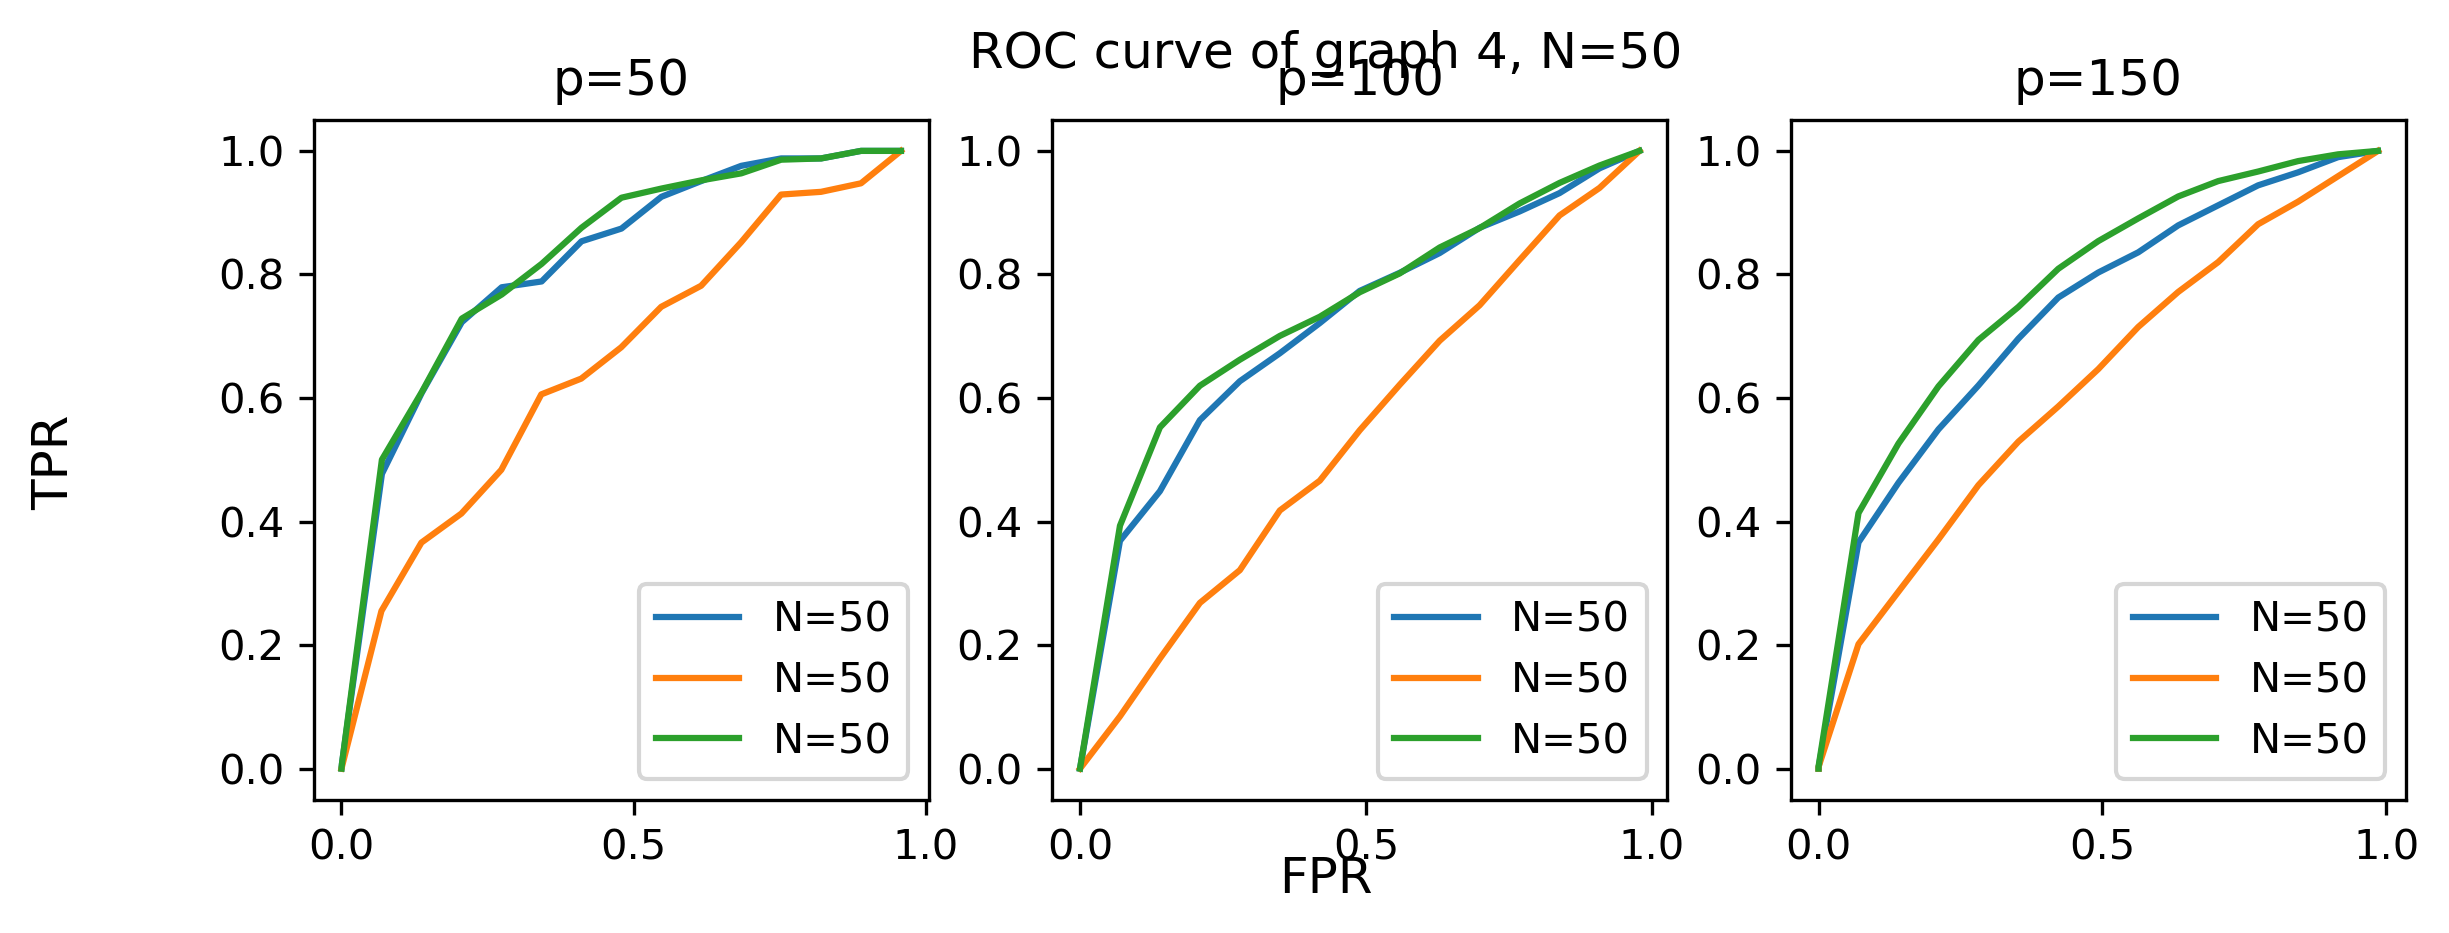

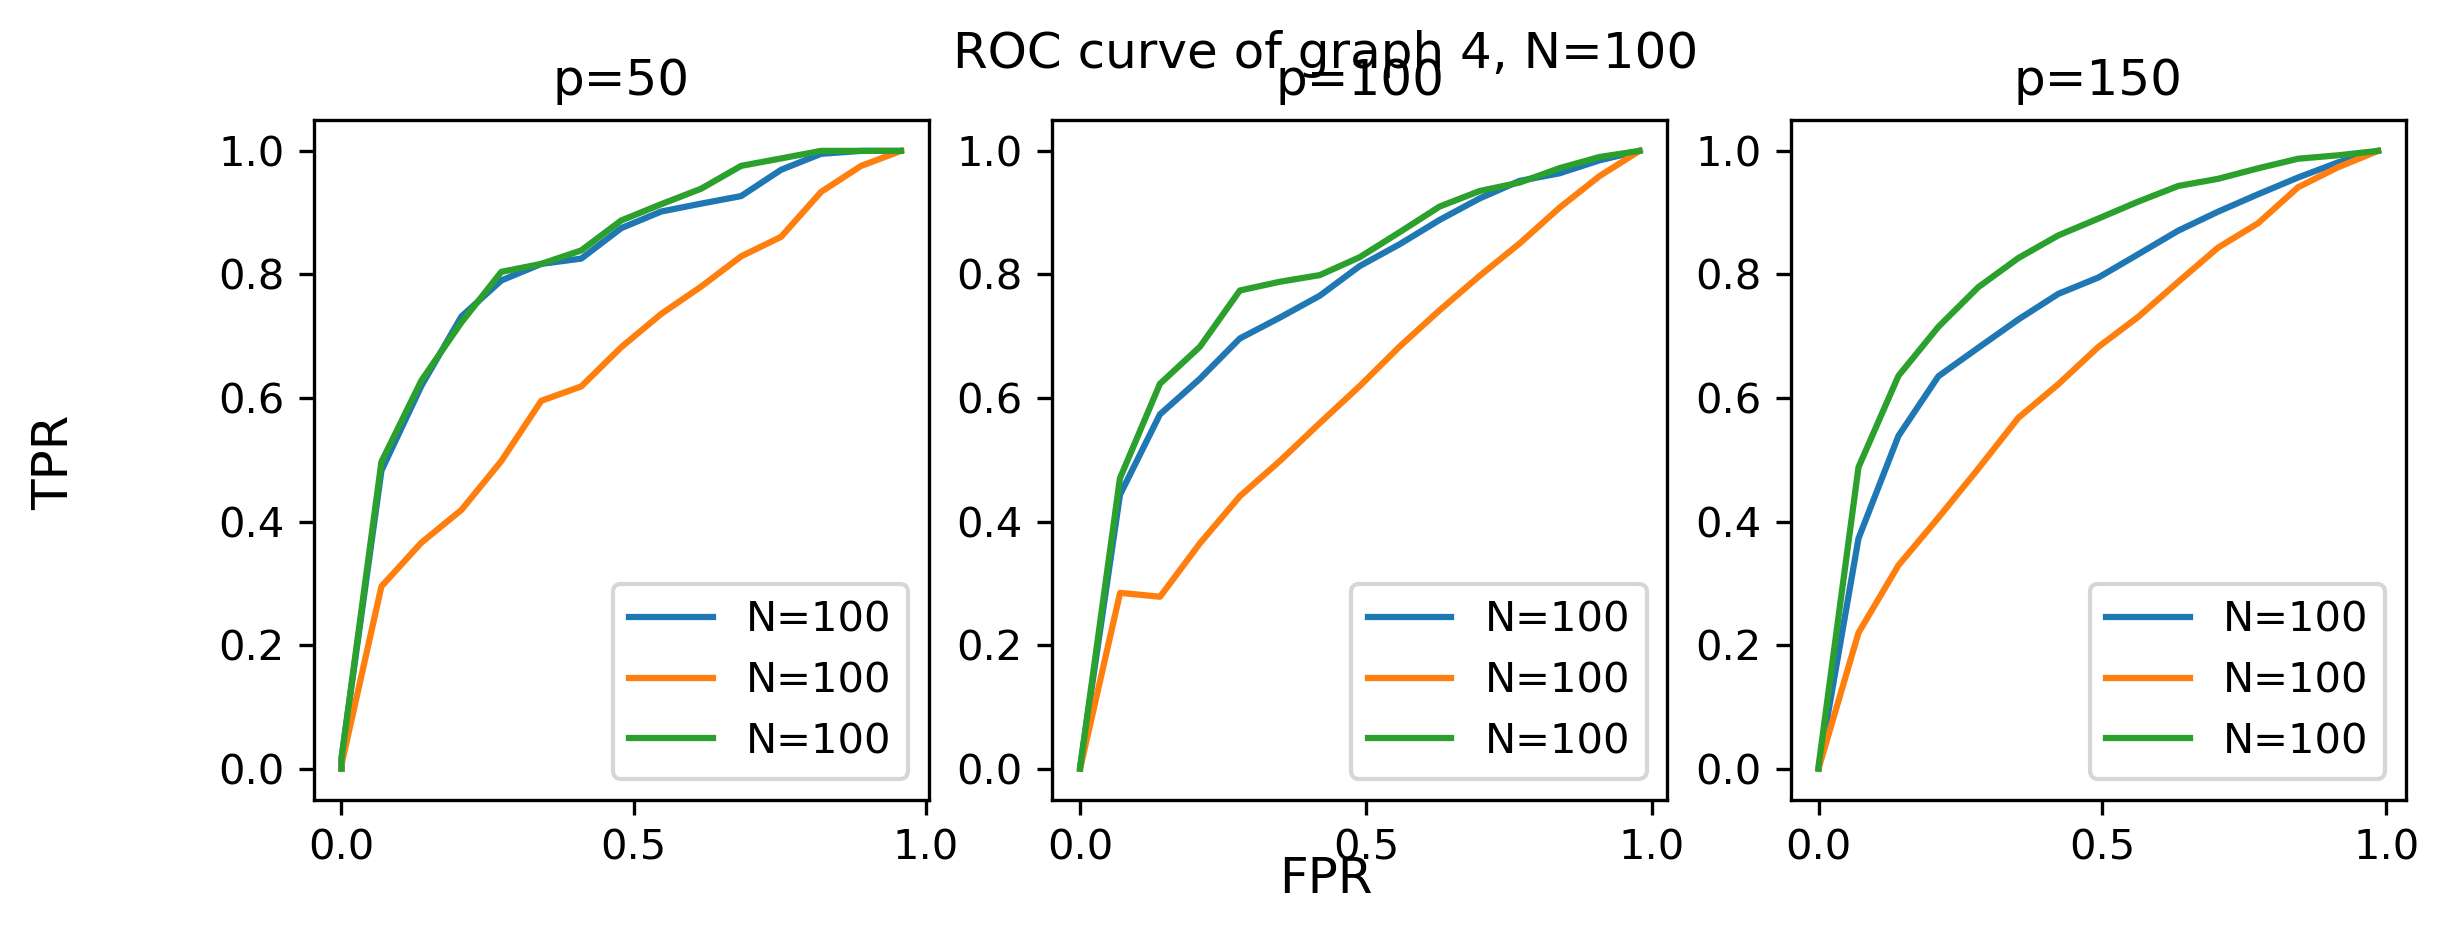

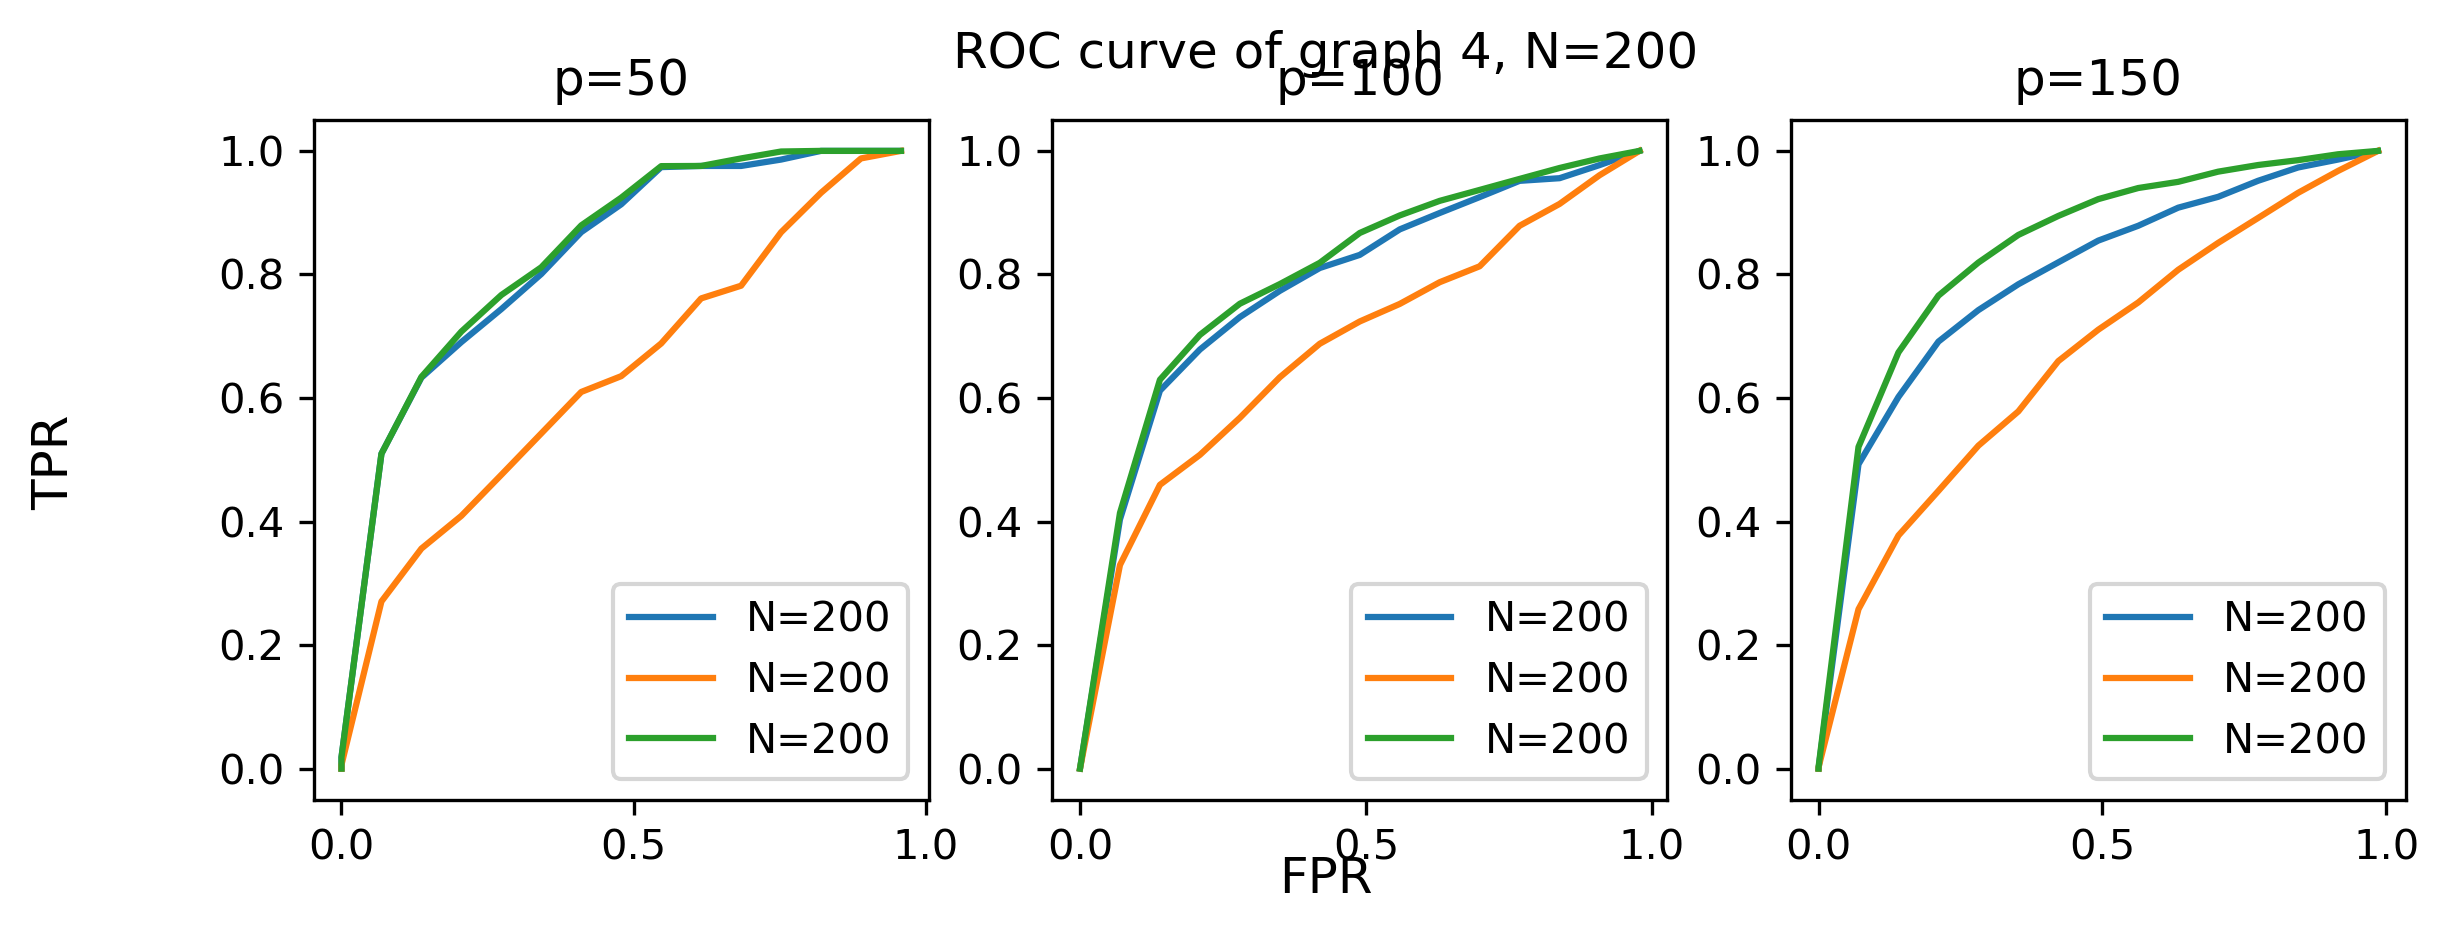

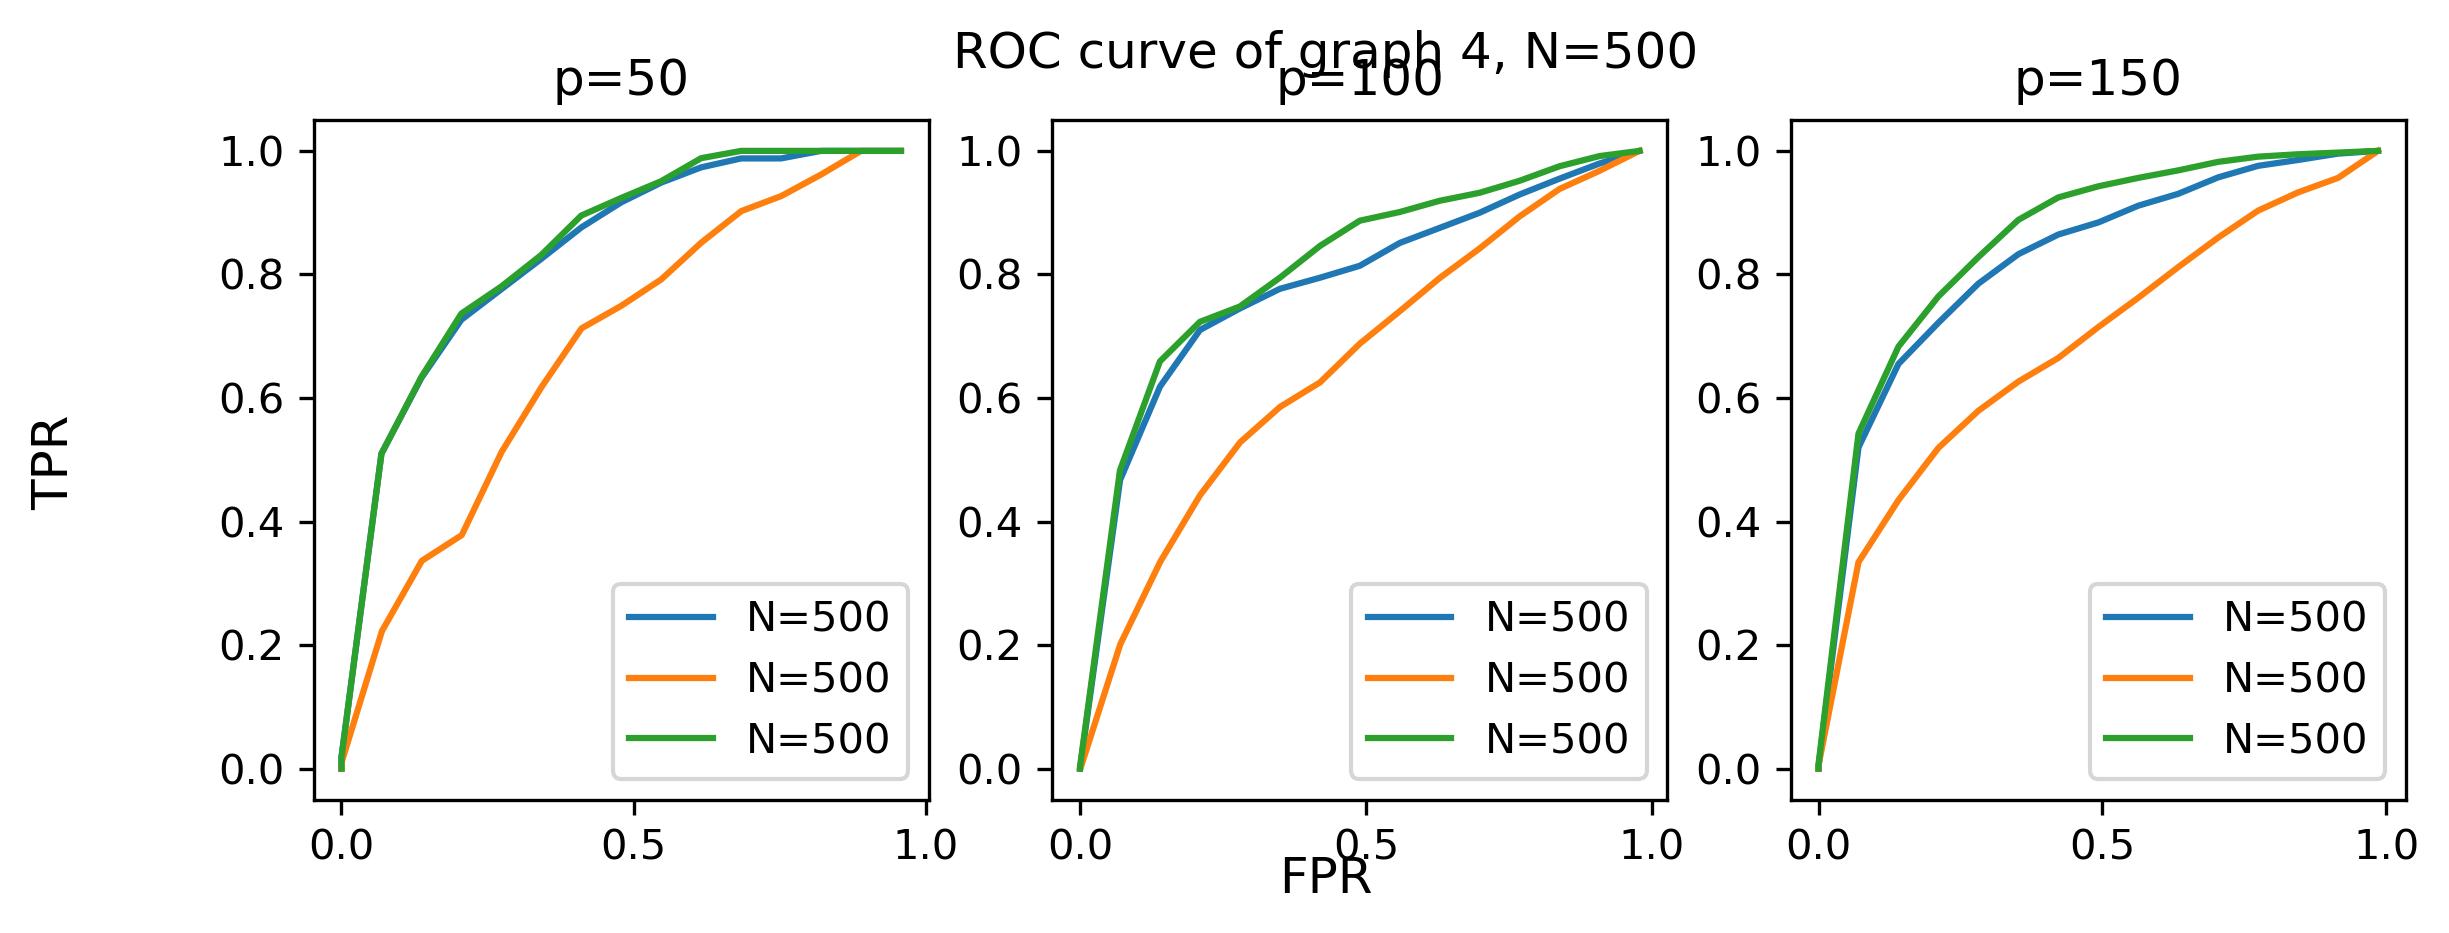

In [50]:
test_model = 'power'
plotplot_noise_level(4, test_model, 50, 1000)
plotplot_noise_level(4, test_model, 100, 1000)
plotplot_noise_level(4, test_model, 200, 1000)
plotplot_noise_level(4, test_model, 500, 1000)


In [304]:
def call_this():


    p_file = model_path+"model3_"+filename+"_Iest_" + noise_model +"_thre0.001_rate{}_run8_tprfpr.npy".format(x)


    arr = np.load(p_file)
    sort_fpr = np.argsort(arr[:,1])

    flng = np.zeros(arr.shape)
    flng[:,0] = arr[sort_fpr,0]
    flng[:,1] = arr[sort_fpr,1]

    m = remove_duplicate(flng[:,1], flng[:,0])
    auc_p = calculate_auc(m)
    if m.shape[0]<=4:
        plt.step(m[:,0], m[:,1], '-o', where='post', label="proposed model")
    else:
        p_fpr, p_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(p_fpr, p_tpr, k=1)
        X_ = np.linspace(np.min(p_fpr), np.max(p_fpr), 50)
        Y_ = X_Y_Spline(X_)
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)),linestyle='solid', label="proposed model")
    
        #plt.plot(m[:,0],m[:,1], linestyle='solid', label="proposed model")
    comparison_filepath = comparison_path+filename+'_'+noise_model+'_light.RunInd4.Rdata'

    def comparison_exist():
        qiao_fpr = np.array(obj['roc']['FPR.qiao'])
        qiao_tpr = np.array(obj['roc']['TPR.qiao'])

        sort_fpr = np.argsort(qiao_fpr)

        qiao = np.zeros((qiao_tpr.shape[0], 2))
        qiao[:,0] = qiao_fpr[sort_fpr]
        qiao[:,1] = qiao_tpr[sort_fpr]
        m = remove_duplicate(qiao[:,0], qiao[:,1])

        #if m.shape[0]<=4:
        ##    plt.step(m[:,0], m[:,1], '-o', where='post', label='Qiao et al., 2019')
        #else:
        q_fpr, q_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(q_fpr, q_tpr, k=1)
        X_ = np.linspace(np.min(q_fpr), np.max(q_fpr), 20)
        Y_ = X_Y_Spline(X_)
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dotted',  label='Qiao et al., 2019')
            #plt.plot(m[:,0],m[:,1], linestyle='dotted', label='Qiao et al., 2019')
        return calculate_auc(m)
    auc_q = 0
    if(exists(comparison_filepath)):
        obj = pyreadr.read_r(comparison_filepath)
        auc_q = comparison_exist()
        
        #print('load file from directory: '+ './results_c_vision/')
    else:
        print("file: "+ comparison_filepath+" not exist")


    def zapata_exist():
        zapata_fpr = np.array(obj['roc']['FPR.zapata'])
        zapata_tpr = np.array(obj['roc']['TPR.zapata'])
        sort_fpr = np.argsort(zapata_fpr)

        zapata = np.zeros((zapata_tpr.shape[0],2))
        zapata[:,0] = zapata_fpr[sort_fpr]
        zapata[:,1] = zapata_tpr[sort_fpr]
        m = remove_duplicate(zapata[:,0], zapata[:,1])

        #if m.shape[0] <= 4:
        #    plt.step(m[:,0], m[:,1], '-o', where='post', label='Zapata et al., 2021')
        #else:
        z_fpr, z_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(z_fpr, z_tpr, k=1)
        X_ = np.linspace(np.min(z_fpr), np.max(z_tpr), 20)
        Y_ = X_Y_Spline(X_)
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashed', label='Zapata et al., 2021')
            #plt.plot(m[:,0],m[:,1], linestyle='dashed', label='Zapata et al., 2021')
        return calculate_auc(m)
    auc_z = 0

    if(exists(comparison_filepath)):
        auc_z = zapata_exist()
    #    pass



    def jfggm_exist():
        jfggm_fpr = np.array(obj['roc']['FPR.jfggm'])
        jfggm_tpr = np.array(obj['roc']['TPR.jfggm'])

        test_num = len(obj['roc']['TPR.jfggm']) // 50
        max_area = 0
        max_i = -1

        #select b that has the largest ROC
        for i in range(test_num):
            tpr_jfggm = obj['roc']['TPR.jfggm'][i*50:(i+1)*50]
            fpr_jfggm = obj['roc']['FPR.jfggm'][i*50:(i+1)*50]
            m = remove_duplicate(fpr_jfggm , tpr_jfggm)
            area = calculate_auc(m)
            #print("index: " , i, " area: ", area)
            if area >= max_area:
                max_area = area
                max_i = i

        #print(max_i)
        tpr_jfggm = obj['roc']['TPR.jfggm'][max_i*50:(max_i+1)*50]
        fpr_jfggm = obj['roc']['FPR.jfggm'][max_i*50:(max_i+1)*50]
        
        sort_fpr = np.argsort(jfggm_fpr)

        jfggm = np.zeros((jfggm_tpr.shape[0],2))
        jfggm[:,0] = jfggm_fpr[sort_fpr]
        jfggm[:,1] = jfggm_tpr[sort_fpr]
        #print(jfggm.shape)
        m = remove_duplicate(jfggm[:,0], jfggm[:,1])
        print(m.shape)
        #if m.shape[0] <= 4:
        #    plt.step(m[:,0], m[:,1], '-o', where='post', label="Moysidis et al., 2021")
        #else:

        m_fpr, m_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(m_fpr, m_tpr, k=1)
        X_ = np.linspace(np.min(m_fpr), np.max(m_fpr), 20)
        Y_ = X_Y_Spline(X_)
        #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashdot', label="Moysidis et al., 2021")
        #plt.plot(m_fpr, m_tpr, linestyle='dashdot', label="Moysidis et al., 2021")

    
    jfggm_filepath = comparison_path+filename+'_'+noise_model+'_jfggm_stage2_100.RunInd1.Rdata'
    if(exists(jfggm_filepath)):
        obj = pyreadr.read_r(jfggm_filepath)
        jfggm_exist()
    else:

        print("file: "+ jfggm_filepath + " not exist")
        pass
    print('proposed', auc_p, 'qiao',auc_q, 'zapata',auc_z)
    plt.legend()
    plt.show()

In [340]:
def compute_avg_auc():

    

    def comparison_exist():
        qiao_fpr = np.array(obj['roc']['FPR.qiao'])
        qiao_tpr = np.array(obj['roc']['TPR.qiao'])

        sort_fpr = np.argsort(qiao_fpr)

        qiao = np.zeros((qiao_tpr.shape[0], 2))
        qiao[:,0] = qiao_fpr[sort_fpr]
        qiao[:,1] = qiao_tpr[sort_fpr]
        m = remove_duplicate(qiao[:,0], qiao[:,1])

        return calculate_auc(m), calculate_auc15(m)

    def zapata_exist():
        zapata_fpr = np.array(obj['roc']['FPR.zapata'])
        zapata_tpr = np.array(obj['roc']['TPR.zapata'])
        sort_fpr = np.argsort(zapata_fpr)

        zapata = np.zeros((zapata_tpr.shape[0],2))
        zapata[:,0] = zapata_fpr[sort_fpr]
        zapata[:,1] = zapata_tpr[sort_fpr]
        m = remove_duplicate(zapata[:,0], zapata[:,1])

        return calculate_auc(m), calculate_auc15(m)

    def jfggm_exist():
        jfggm_fpr = np.array(obj['roc']['FPR.jfggm'])
        jfggm_tpr = np.array(obj['roc']['TPR.jfggm'])

        test_num = len(obj['roc']['TPR.jfggm']) // 50
        max_area = 0
        max_i = -1

        #select b that has the largest ROC
        for i in range(test_num):
            tpr_jfggm = obj['roc']['TPR.jfggm'][i*50:(i+1)*50]
            fpr_jfggm = obj['roc']['FPR.jfggm'][i*50:(i+1)*50]
            m = remove_duplicate(fpr_jfggm , tpr_jfggm)
            area = calculate_auc(m)
            #print("index: " , i, " area: ", area)
            if area >= max_area:
                max_area = area
                max_i = i

        #print(max_i)
        tpr_jfggm = obj['roc']['TPR.jfggm'][max_i*50:(max_i+1)*50]
        fpr_jfggm = obj['roc']['FPR.jfggm'][max_i*50:(max_i+1)*50]
        
        sort_fpr = np.argsort(jfggm_fpr)

        jfggm = np.zeros((jfggm_tpr.shape[0],2))
        jfggm[:,0] = jfggm_fpr[sort_fpr]
        jfggm[:,1] = jfggm_tpr[sort_fpr]
        #print(jfggm.shape)
        m = remove_duplicate(jfggm[:,0], jfggm[:,1])

        return calculate_auc(m), calculate_auc15(m)

    auc_q_list = []
    auc15_q_list = []
    auc_z_list = []
    auc15_z_list = []
    auc_m_list = []
    auc15_m_list = []
    for i in range(10):
        comparison_filepath = comparison_path+"ss_{}/".format(i+1)+filename+'_'+noise_model+'_light.RunInd4.Rdata'

        if(exists(comparison_filepath)):
            obj = pyreadr.read_r(comparison_filepath)
            auc_q, auc15_q = comparison_exist()
            auc_q_list.append(auc_q)
            auc15_q_list.append(auc15_q)

            auc_z, auc15_z = zapata_exist()
            auc_z_list.append(auc_z)
            auc15_z_list.append(auc15_z)
            #print('load file from directory: '+ './results_c_vision/')
        else:
            print("file: "+ comparison_filepath+" not exist")

        
        jfggm_filepath = comparison_path+"ss_{}/".format(i+1)+filename+'_'+noise_model+'_jfggm_stage2_100.RunInd1.Rdata'
        if(exists(jfggm_filepath)):
            obj = pyreadr.read_r(jfggm_filepath)
            auc_m, auc15_m = jfggm_exist()
            auc_m_list.append(auc_m)
            auc15_m_list.append(auc15_m)            
        else:
            print("file: "+ jfggm_filepath + " not exist")
            pass

    auc_q_list = np.array(remove_outlier(auc_q_list))
    auc15_q_list =  np.array(remove_outlier(auc15_q_list))
    auc_z_list = np.array(remove_outlier(auc_z_list))
    auc15_z_list = np.array(remove_outlier(auc15_z_list))
    auc_m_list = np.array(remove_outlier(auc_m_list))
    auc15_m_list = np.array(remove_outlier(auc15_m_list))
    print('Average AUC of qiao et al., 2019', np.mean(auc_q_list), np.std(auc_q_list))
    print('Average AUC15 of qiao et al., 2019', np.mean(auc15_q_list), np.std(auc15_q_list))

    print('Average AUC of zapata et al., 2021', np.mean(auc_z_list), np.std(auc_z_list))
    print('Average AUC15 of zapata et al., 2021', np.mean(auc15_z_list), np.std(auc15_z_list))

    print('Average AUC of Moysidis et al., 2021', np.mean(auc_m_list), np.std(auc_m_list))
    print('Average AUC15 of Moysidis et al., 2021', np.mean(auc15_m_list), np.std(auc15_m_list))

(69, 2)
proposed 0.6567060178656763 qiao 0.59911698913493 zapata 0.8763108537074723


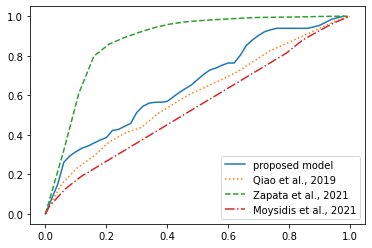

(43, 2)
proposed 0.8635649388134141 qiao 0.7060781730675668 zapata 0.9545808274264415


/Users/katherinetsai/anaconda3/envs/mfggm/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


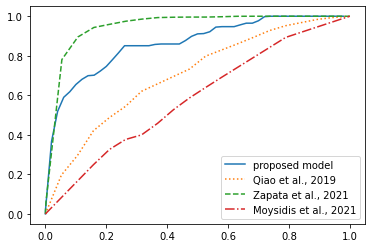

(39, 2)
proposed 0.8975875197325657 qiao 0.7164925432714772 zapata 0.9625193084871629


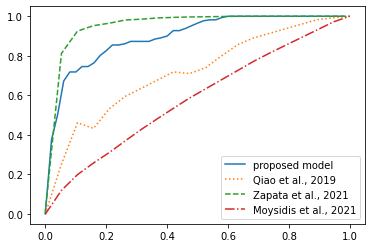

(46, 2)
proposed 0.8444816326530611 qiao 0.6725630280673487 zapata 0.9571965816909089


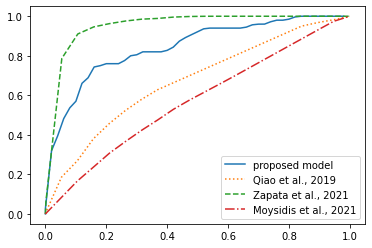

file: /Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results_c20_batch/ss_5/random_p100_N100_noise3_light.RunInd4.Rdata not exist
file: /Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results_c20_batch/ss_5/random_p100_N100_noise3_jfggm_stage2_100.RunInd1.Rdata not exist
proposed 0.8276357053560784 qiao 0 zapata 0


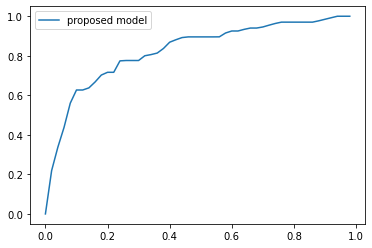

(48, 2)
proposed 0.7762757958726604 qiao 0.5759732462355949 zapata 0.9305423397293472


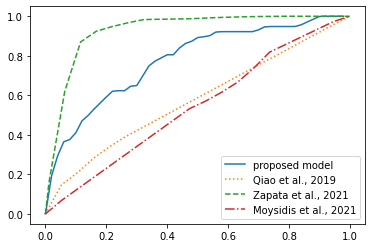

(46, 2)
proposed 0.8546218483055945 qiao 0.6847412135766506 zapata 0.9532549358075305


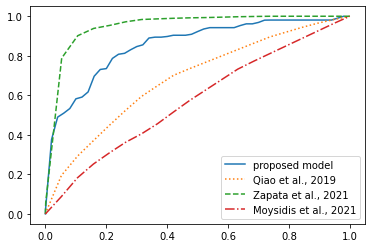

(23, 2)
proposed 0.8143144813122052 qiao 0.7487029425934421 zapata 0.9646077739795725


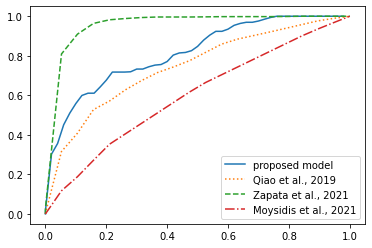

(14, 2)
proposed 0.5428557949154207 qiao 0.5573554133652409 zapata 0.7178967515146991


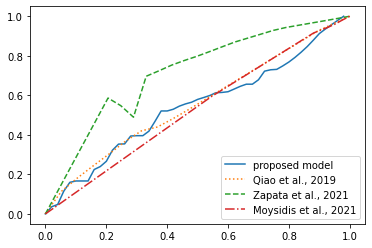

(40, 2)
proposed 0.624538064305671 qiao 0.5886418092200301 zapata 0.8746516818477429


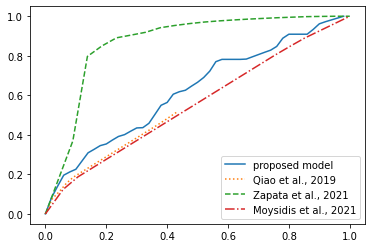

In [345]:
for i in range(10):
    model_path = "/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/ss_{}/".format(i+1)
    x = 332
    comparison_path = "/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results_c20_batch/ss_{}/".format(i+1)
    filename="random_p100_N100"
    noise_model="noise3"
    call_this()

